# Library Imports

In [203]:
library(mvtnorm)
library(psych)
library(MVTests)
library(tidyverse)
library(factoextra)
library(klaR)
library(ggplot2)
library(caret)
library(aplpack)
library(useful)
library(dplyr)
library(corrplot)
library(ellipse)

# Data Import

In [204]:
data0 <- read.csv('Obesity.csv')
head(data0)
str(data0)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,Female,21,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
2,Female,21,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
3,Male,23,1.80,77.0,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
4,Male,27,1.80,87.0,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
5,Male,22,1.78,89.8,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II
6,Male,29,1.62,53.0,no,yes,2,3,Sometimes,no,2,no,0,0,Sometimes,Automobile,Normal_Weight


'data.frame':	2111 obs. of  17 variables:
 $ Gender                        : chr  "Female" "Female" "Male" "Male" ...
 $ Age                           : num  21 21 23 27 22 29 23 22 24 22 ...
 $ Height                        : num  1.62 1.52 1.8 1.8 1.78 1.62 1.5 1.64 1.78 1.72 ...
 $ Weight                        : num  64 56 77 87 89.8 53 55 53 64 68 ...
 $ family_history_with_overweight: chr  "yes" "yes" "yes" "no" ...
 $ FAVC                          : chr  "no" "no" "no" "no" ...
 $ FCVC                          : num  2 3 2 3 2 2 3 2 3 2 ...
 $ NCP                           : num  3 3 3 3 1 3 3 3 3 3 ...
 $ CAEC                          : chr  "Sometimes" "Sometimes" "Sometimes" "Sometimes" ...
 $ SMOKE                         : chr  "no" "yes" "no" "no" ...
 $ CH2O                          : num  2 3 2 2 2 2 2 2 2 2 ...
 $ SCC                           : chr  "no" "yes" "no" "no" ...
 $ FAF                           : num  0 3 2 2 0 0 1 3 1 1 ...
 $ TUE                          

<b>We see that our dataset contains 17 variables: 8 quantitative and 9 qualitative</b>

# Data Preprocessing

<b>Since we are only interested in performing a multivariate analysis, I will drop all qualitative variables except for MTRANS and NObeyesdad (response variable)</b>

In [205]:
data_trimmed <- data0[, sapply(data0, is.numeric)]
data_trimmed$MTRANS <- data0$MTRANS
data_trimmed$NObeyesdad <- data0$NObeyesdad
head(data_trimmed)

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,MTRANS,NObeyesdad
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,21,1.62,64.0,2,3,2,0,1,Public_Transportation,Normal_Weight
2,21,1.52,56.0,3,3,3,3,0,Public_Transportation,Normal_Weight
3,23,1.80,77.0,2,3,2,2,1,Public_Transportation,Normal_Weight
4,27,1.80,87.0,3,3,2,2,0,Walking,Overweight_Level_I
5,22,1.78,89.8,2,1,2,0,0,Public_Transportation,Overweight_Level_II
6,29,1.62,53.0,2,3,2,0,0,Automobile,Normal_Weight


<b>Let's rename our variables to allow for better interpretability.</b>

In [206]:
names(data_trimmed)[names(data_trimmed)=='FCVC'] <- 'Vegetables'
names(data_trimmed)[names(data_trimmed)=='NCP'] <- 'Meals'
names(data_trimmed)[names(data_trimmed)=='CH2O'] <- 'LitersWater'
names(data_trimmed)[names(data_trimmed)=='FAF'] <- 'HoursExercise'
names(data_trimmed)[names(data_trimmed)=='TUE'] <- 'HoursTechnology'
names(data_trimmed)[names(data_trimmed)=='MTRANS'] <- 'MethodTransportation'
names(data_trimmed)[names(data_trimmed)=='NObeyesdad'] <- 'ObesityLevel'

In [207]:
head(data_trimmed)

,Age,Height,Weight,Vegetables,Meals,LitersWater,HoursExercise,HoursTechnology,MethodTransportation,ObesityLevel
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,21,1.62,64.0,2,3,2,0,1,Public_Transportation,Normal_Weight
2,21,1.52,56.0,3,3,3,3,0,Public_Transportation,Normal_Weight
3,23,1.80,77.0,2,3,2,2,1,Public_Transportation,Normal_Weight
4,27,1.80,87.0,3,3,2,2,0,Walking,Overweight_Level_I
5,22,1.78,89.8,2,1,2,0,0,Public_Transportation,Overweight_Level_II
6,29,1.62,53.0,2,3,2,0,0,Automobile,Normal_Weight


In [208]:
unique(data_trimmed$ObesityLevel)

[1] "Normal_Weight"       "Overweight_Level_I"  "Overweight_Level_II"
[4] "Obesity_Type_I"      "Insufficient_Weight" "Obesity_Type_II"    
[7] "Obesity_Type_III"

# Currently there are 7 classes of ObesityLevel, I will trim this down to 4 levels:
## Underweight, Normal, Overweight, Obese

In [209]:
data_trimmed <- data_trimmed %>% mutate(ObesityLevel = recode(ObesityLevel,'Overweight_Level_I' = 'Overweight', 
                                                            'Overweight_Level_II' = 'Overweight',
                                                             'Obesity_Type_I' = 'Obese',
                                                             'Obesity_Type_II' = 'Obese',
                                                             'Obesity_Type_III' = 'Obese'))
head(data_trimmed)

,Age,Height,Weight,Vegetables,Meals,LitersWater,HoursExercise,HoursTechnology,MethodTransportation,ObesityLevel
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,21,1.62,64.0,2,3,2,0,1,Public_Transportation,Normal_Weight
2,21,1.52,56.0,3,3,3,3,0,Public_Transportation,Normal_Weight
3,23,1.80,77.0,2,3,2,2,1,Public_Transportation,Normal_Weight
4,27,1.80,87.0,3,3,2,2,0,Walking,Overweight
5,22,1.78,89.8,2,1,2,0,0,Public_Transportation,Overweight
6,29,1.62,53.0,2,3,2,0,0,Automobile,Normal_Weight


In [210]:
data_trimmed <- data_trimmed %>% mutate(ObesityLevel = recode(ObesityLevel, 'Normal_Weight' = 'Average',
                                                             'Insufficient_Weight' = 'Underweight'))
head(data_trimmed)

,Age,Height,Weight,Vegetables,Meals,LitersWater,HoursExercise,HoursTechnology,MethodTransportation,ObesityLevel
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,21,1.62,64.0,2,3,2,0,1,Public_Transportation,Average
2,21,1.52,56.0,3,3,3,3,0,Public_Transportation,Average
3,23,1.80,77.0,2,3,2,2,1,Public_Transportation,Average
4,27,1.80,87.0,3,3,2,2,0,Walking,Overweight
5,22,1.78,89.8,2,1,2,0,0,Public_Transportation,Overweight
6,29,1.62,53.0,2,3,2,0,0,Automobile,Average


In [211]:
unique(data_trimmed$ObesityLevel)

[1] "Average"     "Overweight"  "Obese"       "Underweight"

# Next, I will convert my qualitative variables into factors in order to apply our statistical methods to them later.

In [212]:
data_trimmed$MethodTransportation <- as.factor(data_trimmed$MethodTransportation)
data_trimmed$ObesityLevel <- as.factor(data_trimmed$ObesityLevel)
str(data_trimmed)

'data.frame':	2111 obs. of  10 variables:
 $ Age                 : num  21 21 23 27 22 29 23 22 24 22 ...
 $ Height              : num  1.62 1.52 1.8 1.8 1.78 1.62 1.5 1.64 1.78 1.72 ...
 $ Weight              : num  64 56 77 87 89.8 53 55 53 64 68 ...
 $ Vegetables          : num  2 3 2 3 2 2 3 2 3 2 ...
 $ Meals               : num  3 3 3 3 1 3 3 3 3 3 ...
 $ LitersWater         : num  2 3 2 2 2 2 2 2 2 2 ...
 $ HoursExercise       : num  0 3 2 2 0 0 1 3 1 1 ...
 $ HoursTechnology     : num  1 0 1 0 0 0 0 0 1 1 ...
 $ MethodTransportation: Factor w/ 5 levels "Automobile","Bike",..: 4 4 4 5 4 1 3 4 4 4 ...
 $ ObesityLevel        : Factor w/ 4 levels "Average","Obese",..: 1 1 1 3 3 1 1 1 1 1 ...


# Now let's examine a few univariate statistics before we move on to multivariate statistics

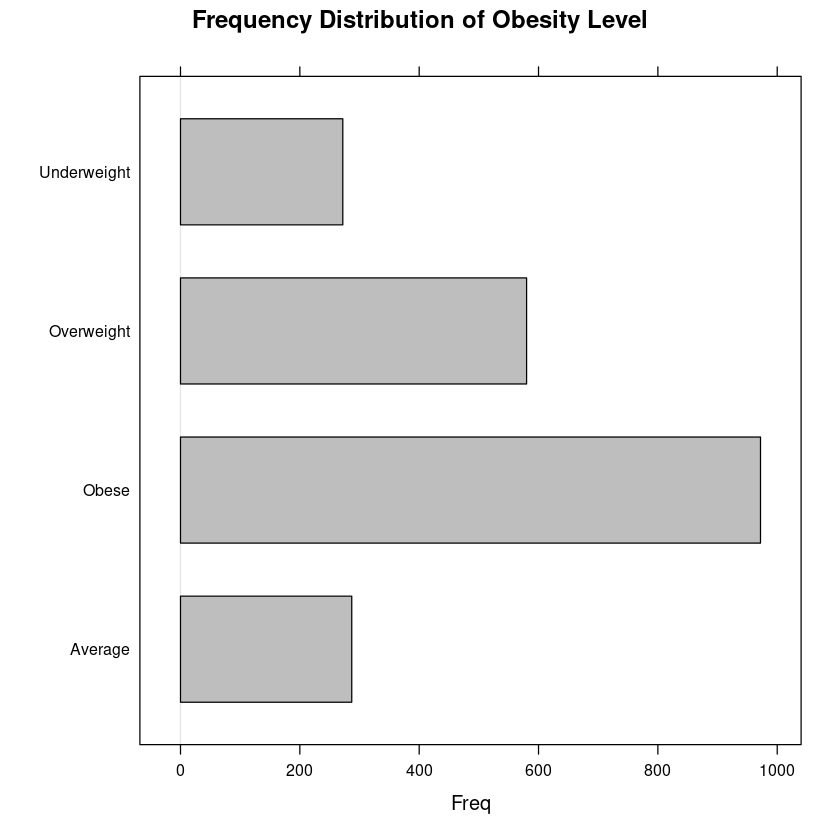

In [213]:
barchart(data_trimmed$ObesityLevel, main="Frequency Distribution of Obesity Level", c='gray')

In [214]:
summary(data_trimmed[,1:8])

      Age            Height          Weight         Vegetables   
 Min.   :14.00   Min.   :1.450   Min.   : 39.00   Min.   :1.000  
 1st Qu.:19.95   1st Qu.:1.630   1st Qu.: 65.47   1st Qu.:2.000  
 Median :22.78   Median :1.700   Median : 83.00   Median :2.386  
 Mean   :24.31   Mean   :1.702   Mean   : 86.59   Mean   :2.419  
 3rd Qu.:26.00   3rd Qu.:1.768   3rd Qu.:107.43   3rd Qu.:3.000  
 Max.   :61.00   Max.   :1.980   Max.   :173.00   Max.   :3.000  
     Meals        LitersWater    HoursExercise    HoursTechnology 
 Min.   :1.000   Min.   :1.000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:2.659   1st Qu.:1.585   1st Qu.:0.1245   1st Qu.:0.0000  
 Median :3.000   Median :2.000   Median :1.0000   Median :0.6253  
 Mean   :2.686   Mean   :2.008   Mean   :1.0103   Mean   :0.6579  
 3rd Qu.:3.000   3rd Qu.:2.477   3rd Qu.:1.6667   3rd Qu.:1.0000  
 Max.   :4.000   Max.   :3.000   Max.   :3.0000   Max.   :2.0000  

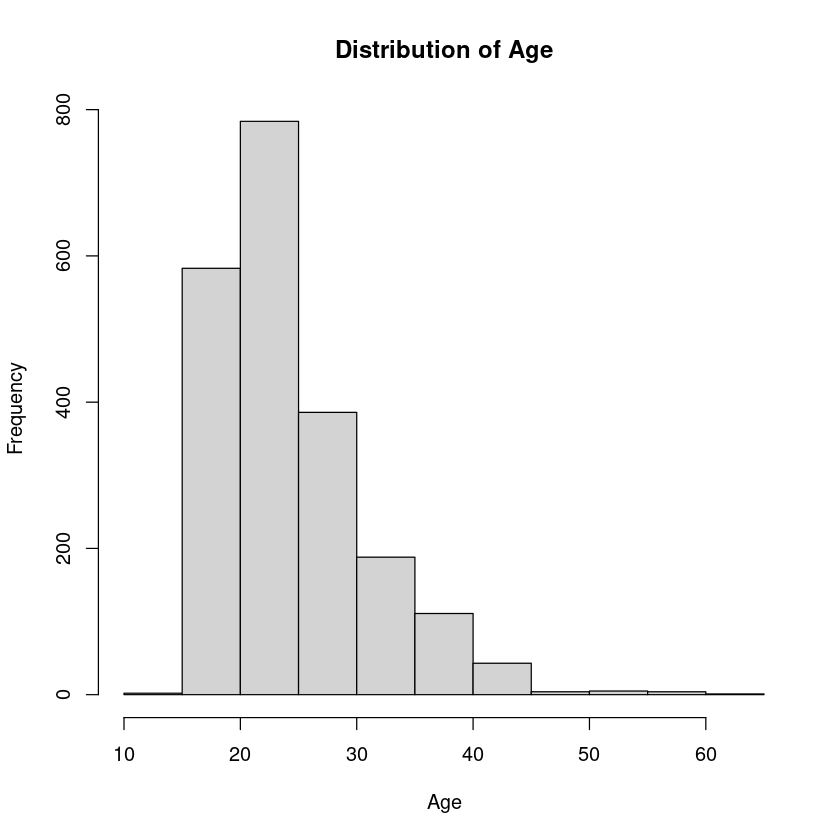

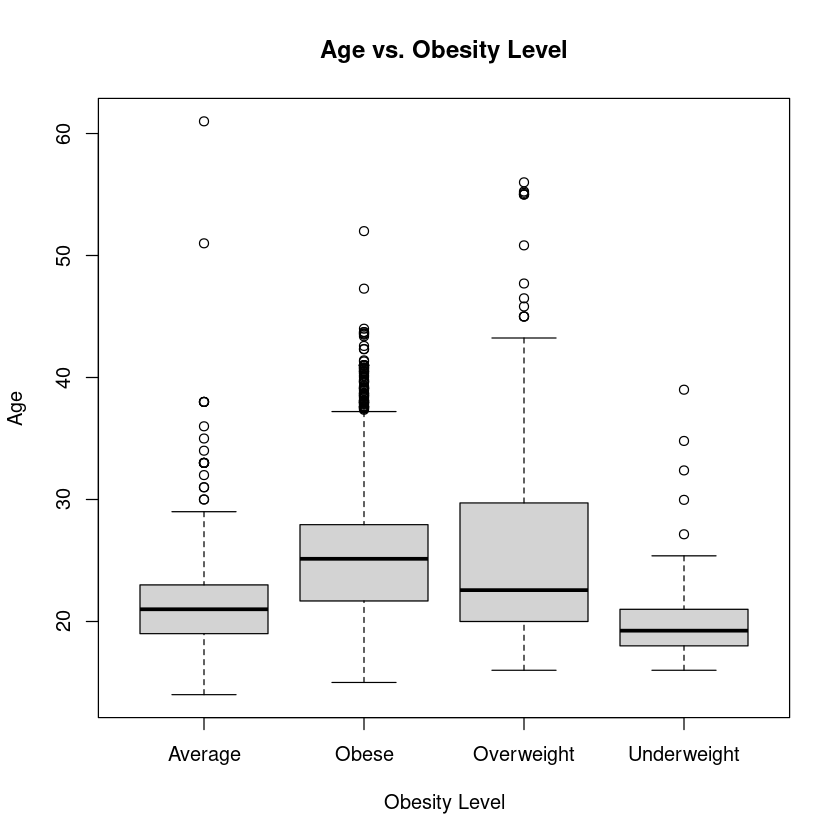

In [215]:
hist(data_trimmed$Age, main='Distribution of Age', xlab='Age')
boxplot(data_trimmed$Age~data_trimmed$ObesityLevel, main='Age vs. Obesity Level', xlab='Obesity Level', ylab='Age')

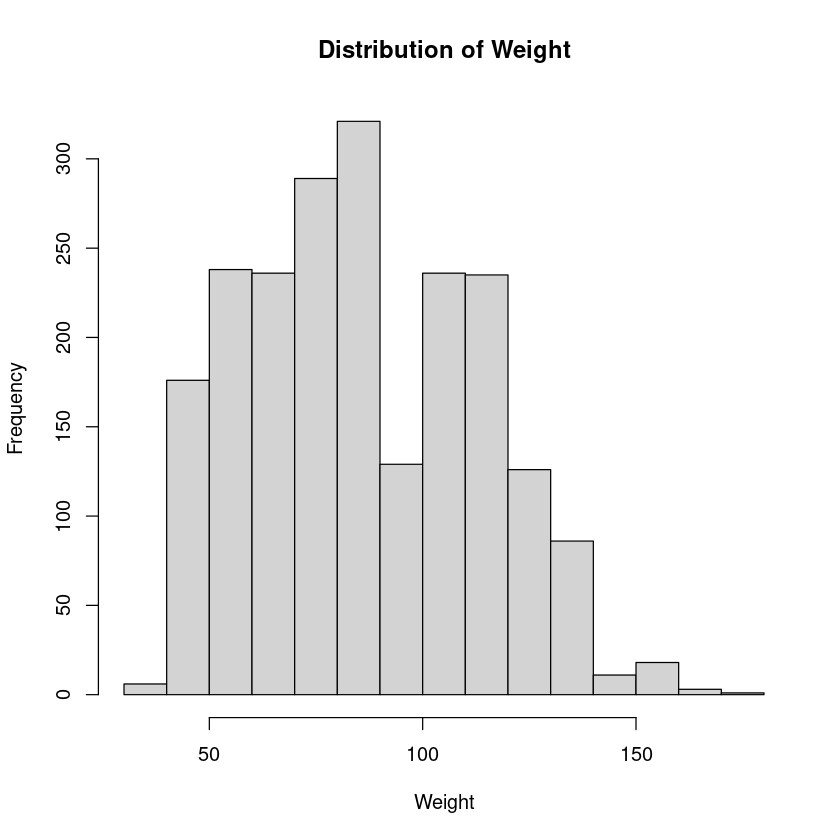

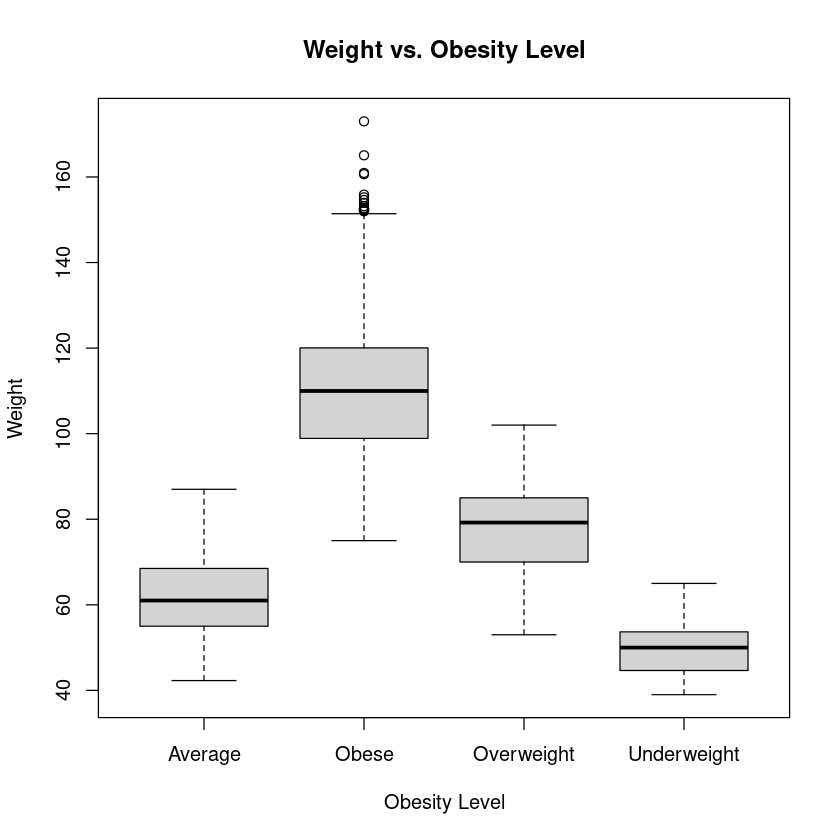

In [216]:
hist(data_trimmed$Weight, main='Distribution of Weight', xlab='Weight')
boxplot(data_trimmed$Weight~data_trimmed$ObesityLevel, main='Weight vs. Obesity Level', xlab='Obesity Level', ylab='Weight')

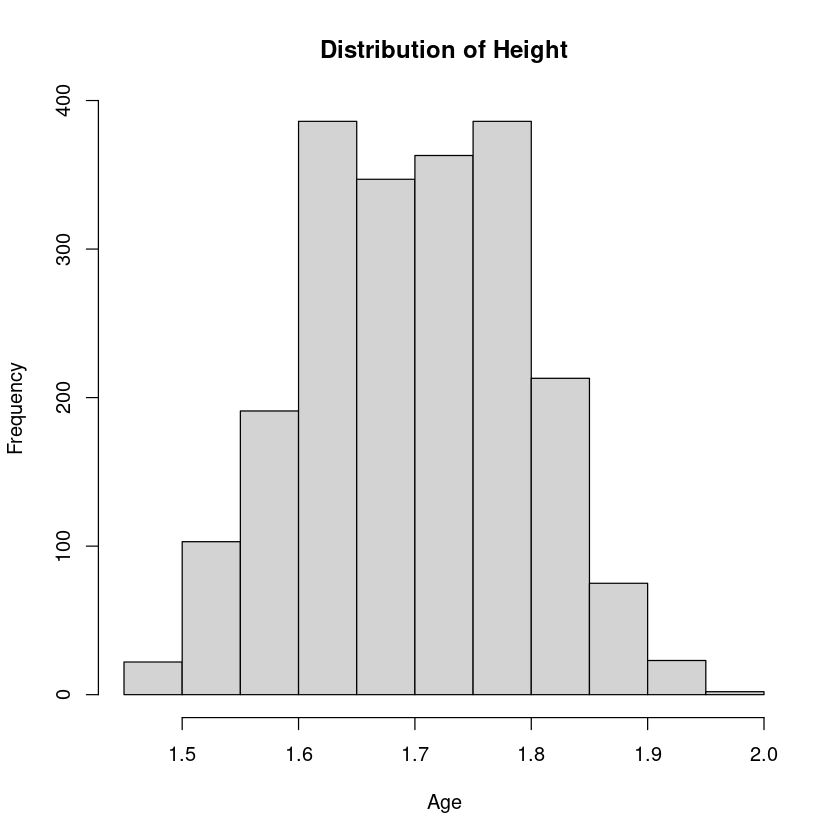

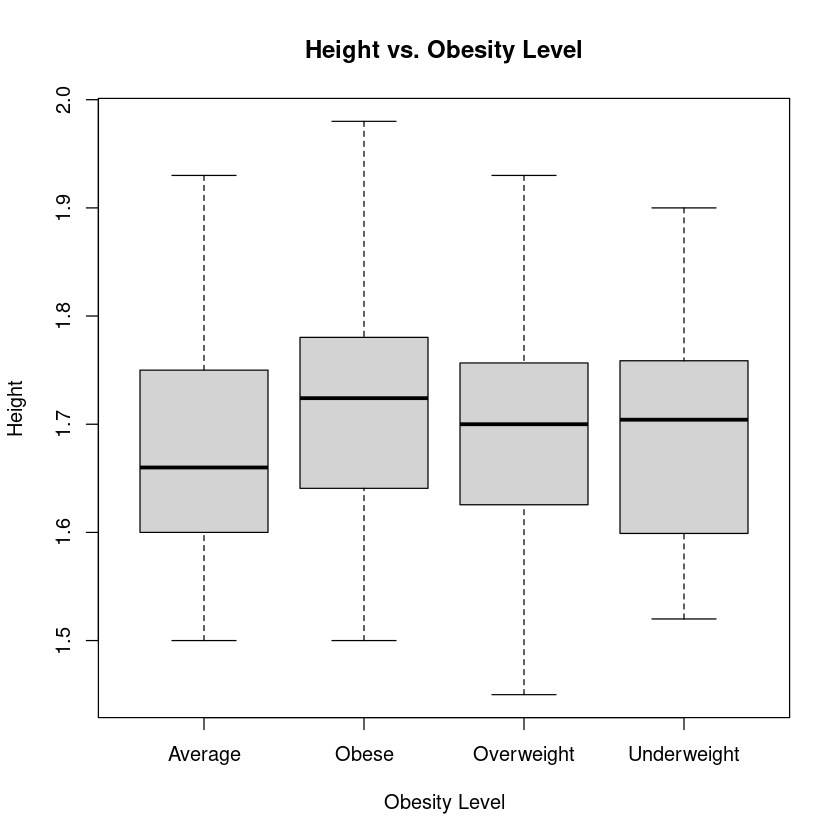

In [217]:
hist(data_trimmed$Height, main='Distribution of Height', xlab='Age')
boxplot(data_trimmed$Height~data_trimmed$ObesityLevel, main='Height vs. Obesity Level', xlab='Obesity Level', ylab='Height')

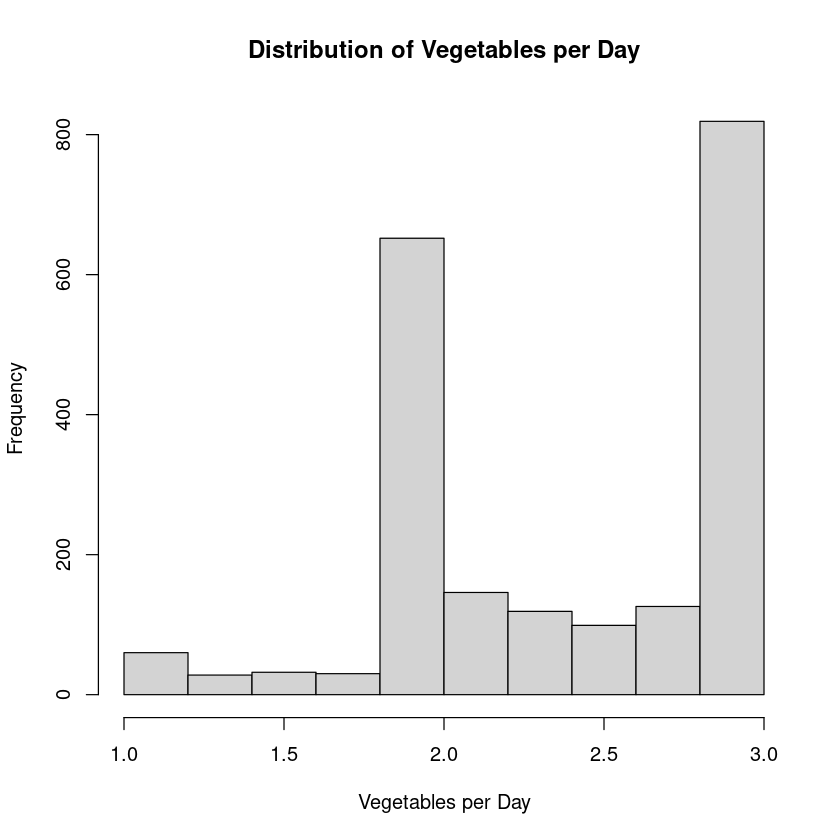

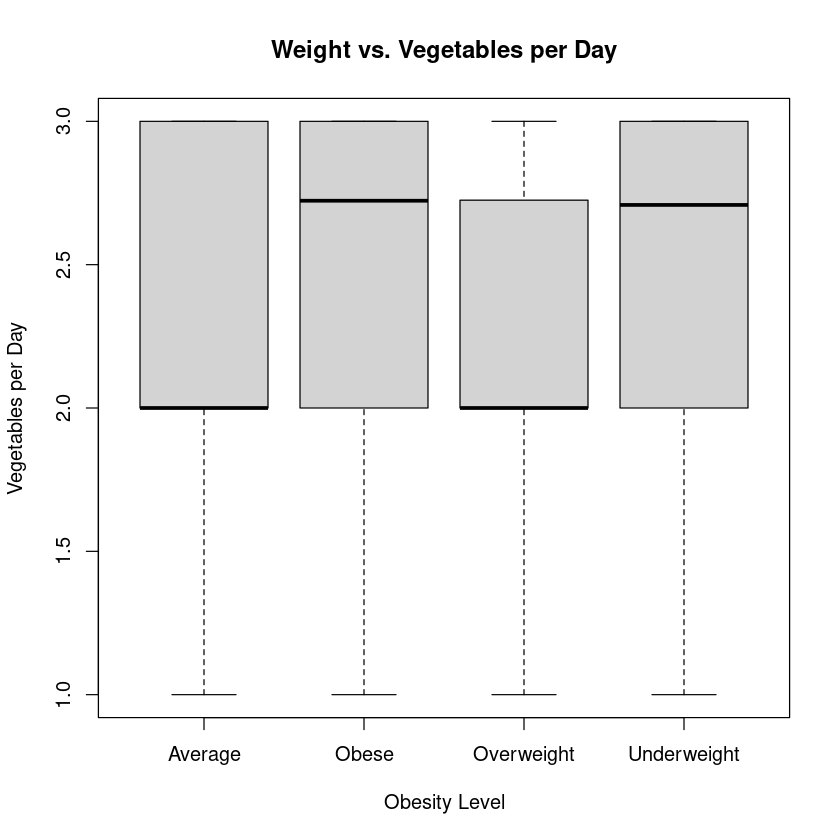

In [218]:
hist(data_trimmed$Vegetables, main='Distribution of Vegetables per Day', xlab='Vegetables per Day')
boxplot(data_trimmed$Vegetables~data_trimmed$ObesityLevel, main='Weight vs. Vegetables per Day', xlab='Obesity Level', ylab='Vegetables per Day')

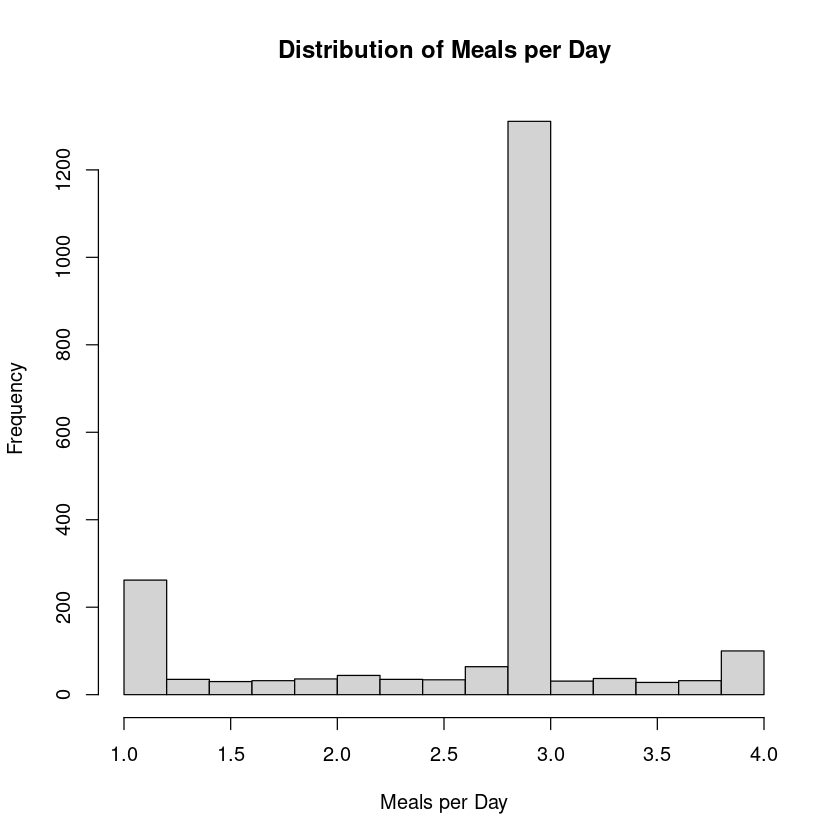

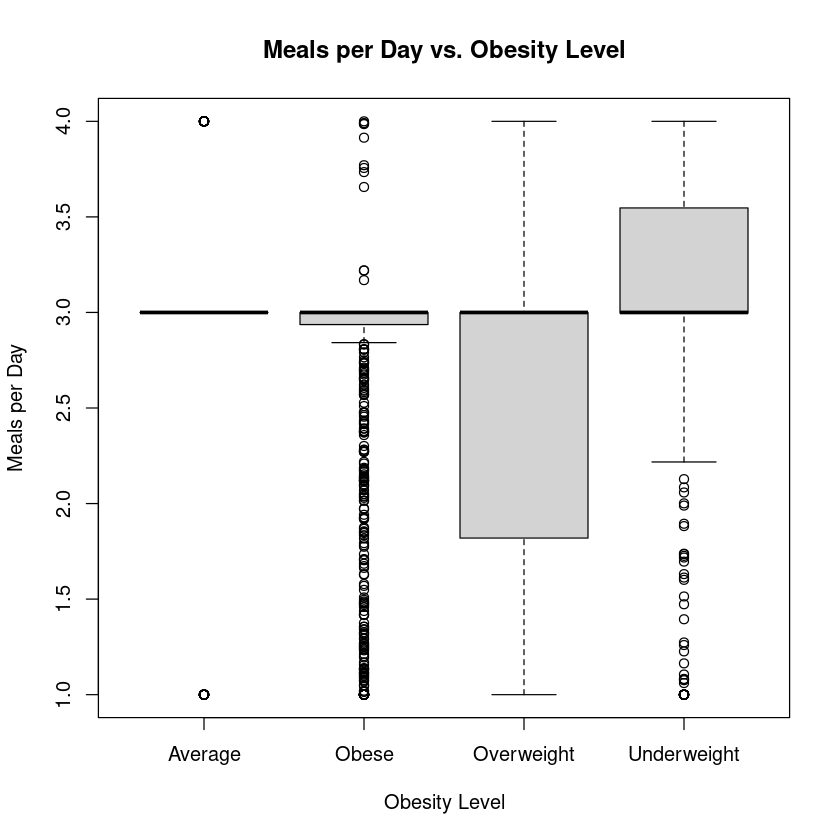

In [219]:
hist(data_trimmed$Meals, main='Distribution of Meals per Day', xlab='Meals per Day')
boxplot(data_trimmed$Meals~data_trimmed$ObesityLevel, main='Meals per Day vs. Obesity Level', xlab='Obesity Level', ylab='Meals per Day')

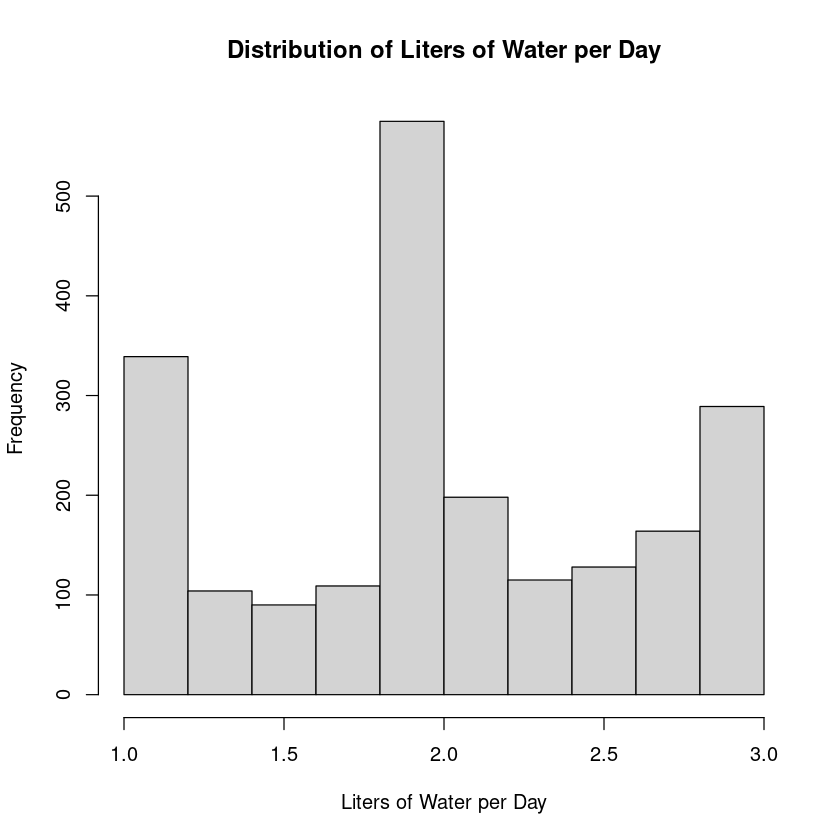

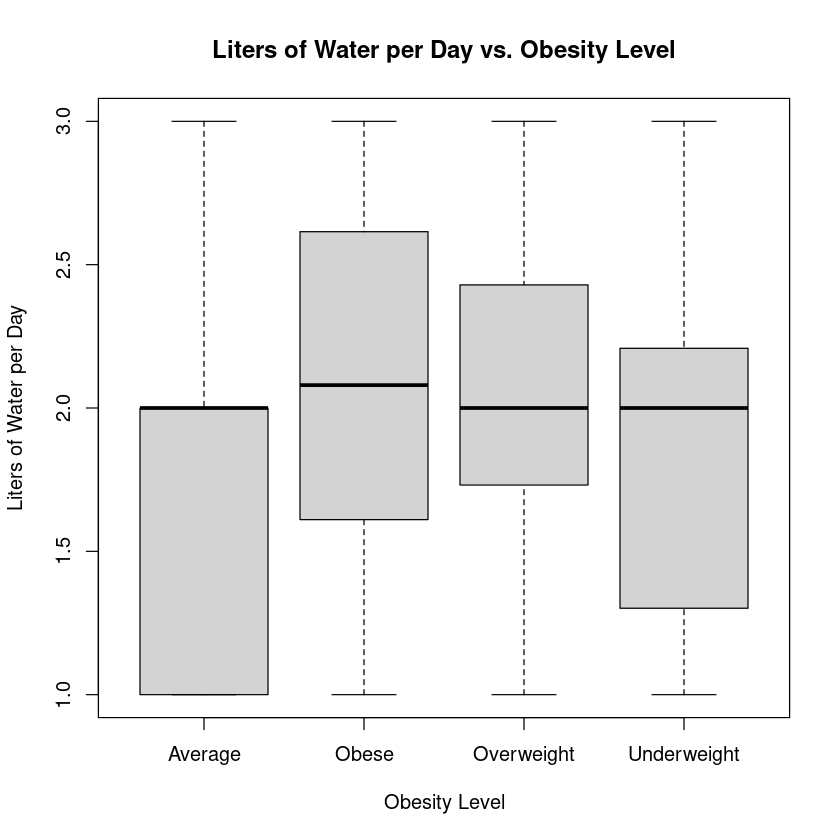

In [220]:
hist(data_trimmed$LitersWater, main='Distribution of Liters of Water per Day', xlab='Liters of Water per Day')
boxplot(data_trimmed$LitersWater~data_trimmed$ObesityLevel, main='Liters of Water per Day vs. Obesity Level', xlab='Obesity Level', ylab='Liters of Water per Day')

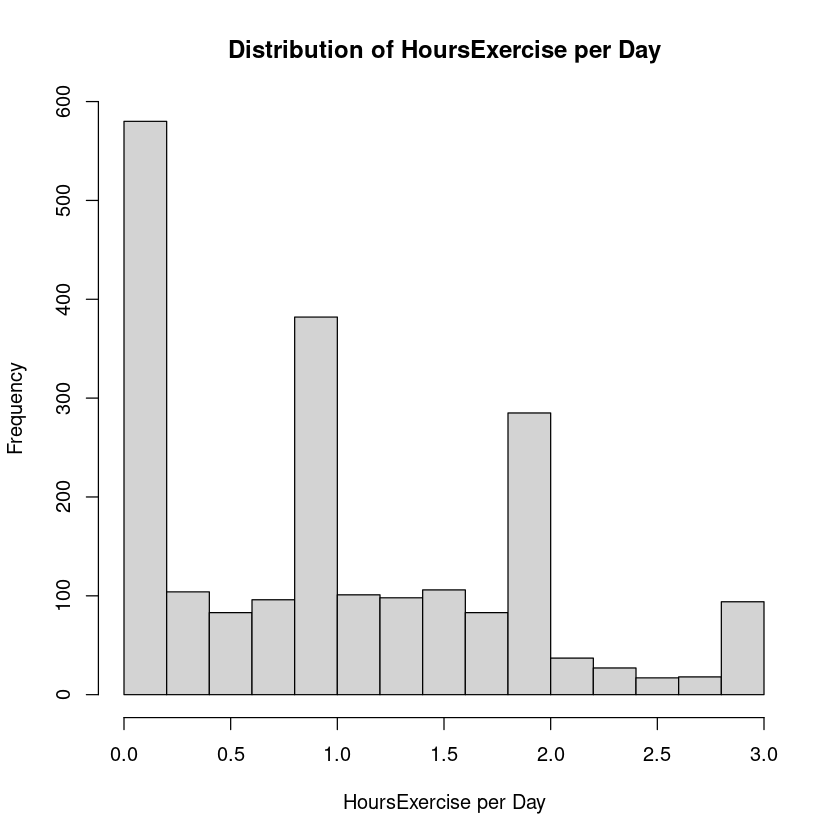

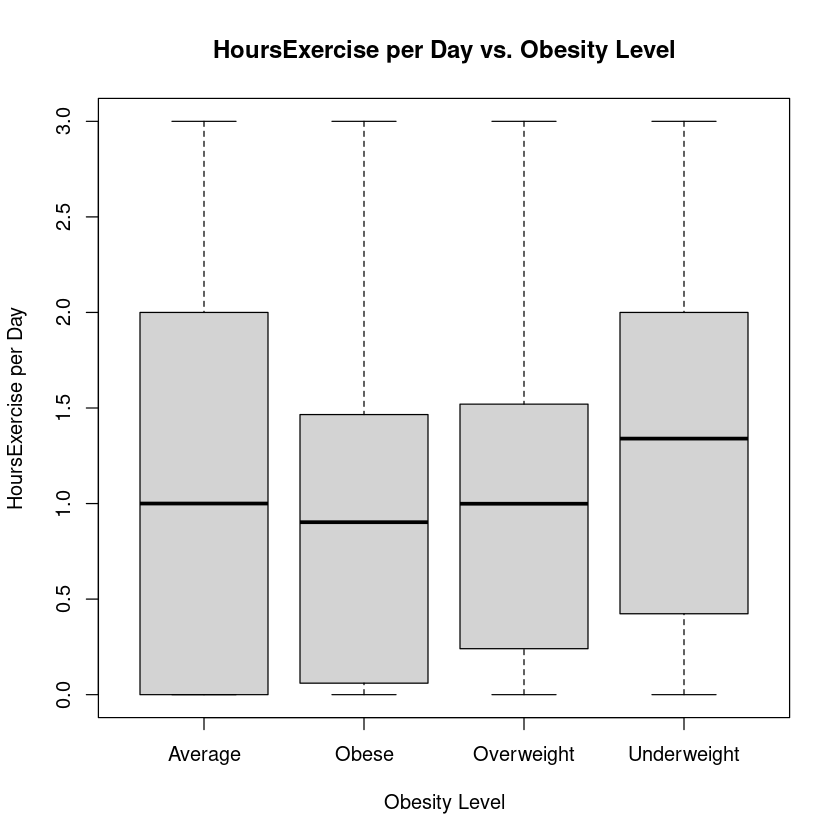

In [221]:
hist(data_trimmed$HoursExercise, main='Distribution of HoursExercise per Day', xlab='HoursExercise per Day')
boxplot(data_trimmed$HoursExercise~data_trimmed$ObesityLevel, main='HoursExercise per Day vs. Obesity Level', xlab='Obesity Level', ylab='HoursExercise per Day')

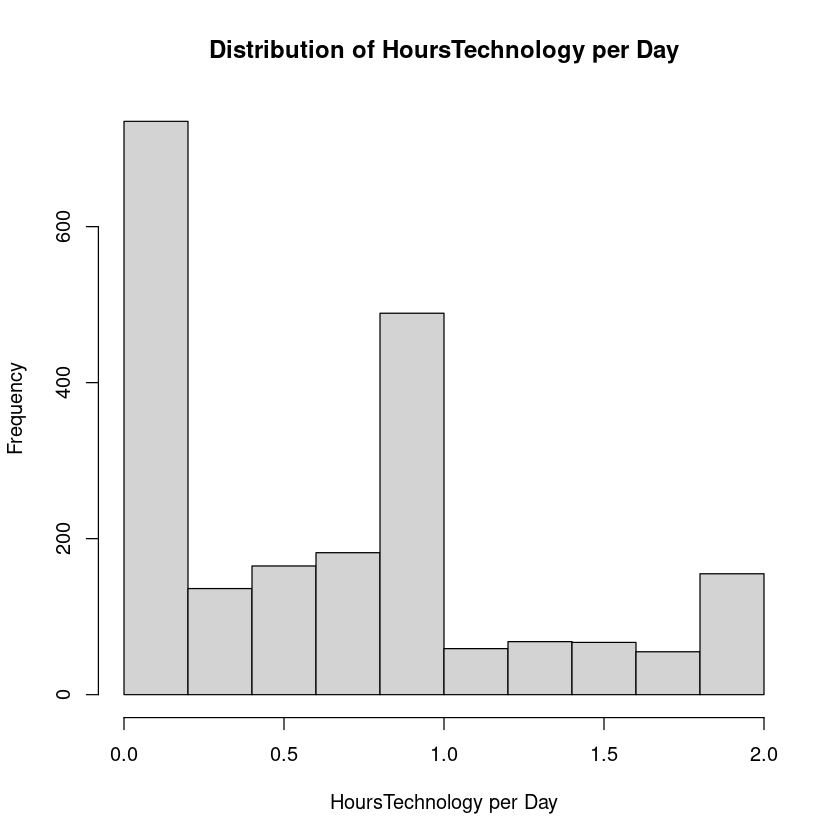

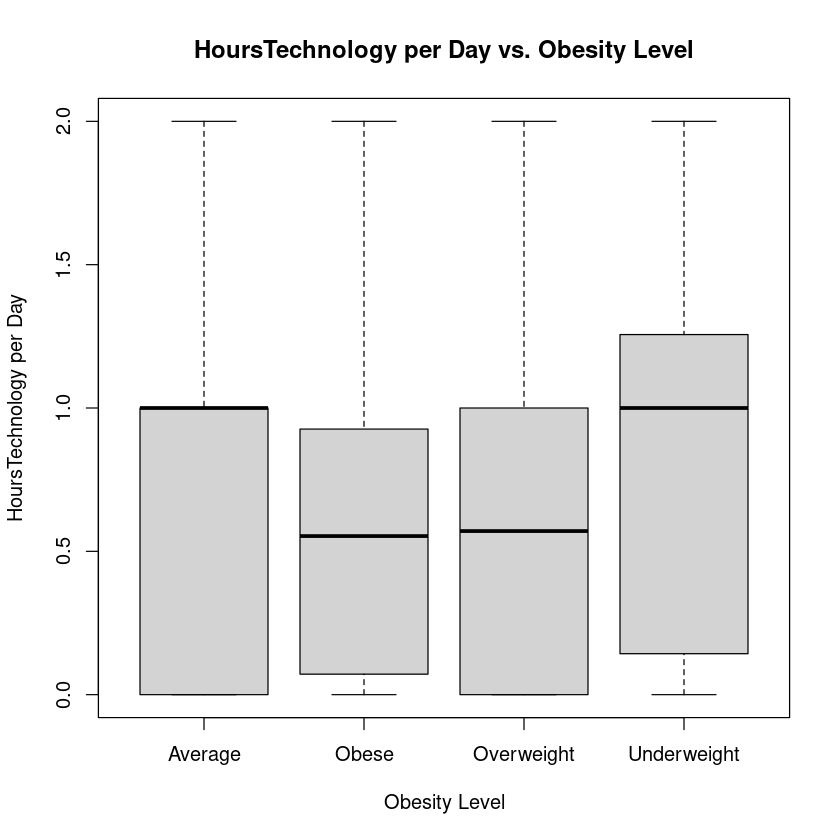

In [222]:
hist(data_trimmed$HoursTechnology, main='Distribution of HoursTechnology per Day', xlab='HoursTechnology per Day')
boxplot(data_trimmed$HoursTechnology~data_trimmed$ObesityLevel, main='HoursTechnology per Day vs. Obesity Level', xlab='Obesity Level', ylab='HoursTechnology per Day')

In [223]:
table(data_trimmed$ObesityLevel, data_trimmed$MethodTransportation)

             
              Automobile Bike Motorbike Public_Transportation Walking
  Average             45    4         6                   200      32
  Obese              206    1         3                   759       3
  Overweight         160    2         2                   401      15
  Underweight         46    0         0                   220       6

,Age,Height,Weight,Vegetables,Meals,LitersWater,HoursExercise,HoursTechnology
Age,1.00000000,-0.02595813,0.20256010,0.01629089,-0.04394373,-0.04530386,-0.14493833,-0.29693059
Height,-0.02595813,1.00000000,0.46313612,-0.03812106,0.24367173,0.21337592,0.29470900,0.05191167
Weight,0.20256010,0.46313612,1.00000000,0.21612471,0.10746899,0.20057539,-0.05143627,-0.07156136
Vegetables,0.01629089,-0.03812106,0.21612471,1.00000000,0.04221630,0.06846147,0.01993940,-0.10113485
Meals,-0.04394373,0.24367173,0.10746899,0.04221630,1.00000000,0.05708800,0.12950431,0.03632557
LitersWater,-0.04530386,0.21337592,0.20057539,0.06846147,0.05708800,1.00000000,0.16723649,0.01196534
HoursExercise,-0.14493833,0.29470900,-0.05143627,0.01993940,0.12950431,0.16723649,1.00000000,0.05856207
HoursTechnology,-0.29693059,0.05191167,-0.07156136,-0.10113485,0.03632557,0.01196534,0.05856207,1.00000000


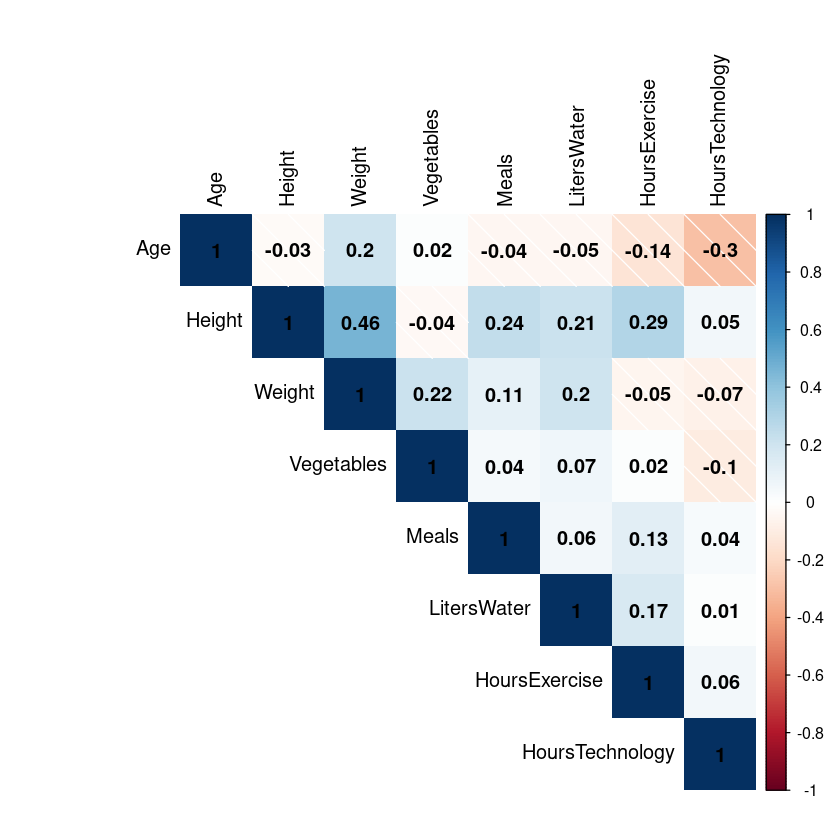

In [224]:
correlations = cor(data_trimmed[,1:8])
correlations
corrplot(correlations, method = "shade", tl.col = "black", addCoef.col = "black", type='upper')

<b>We see that all variables are weakly correlated, indicating a lack of multicollinearity.</b>

# Let's now examine the univariate normality of our variables

## Age

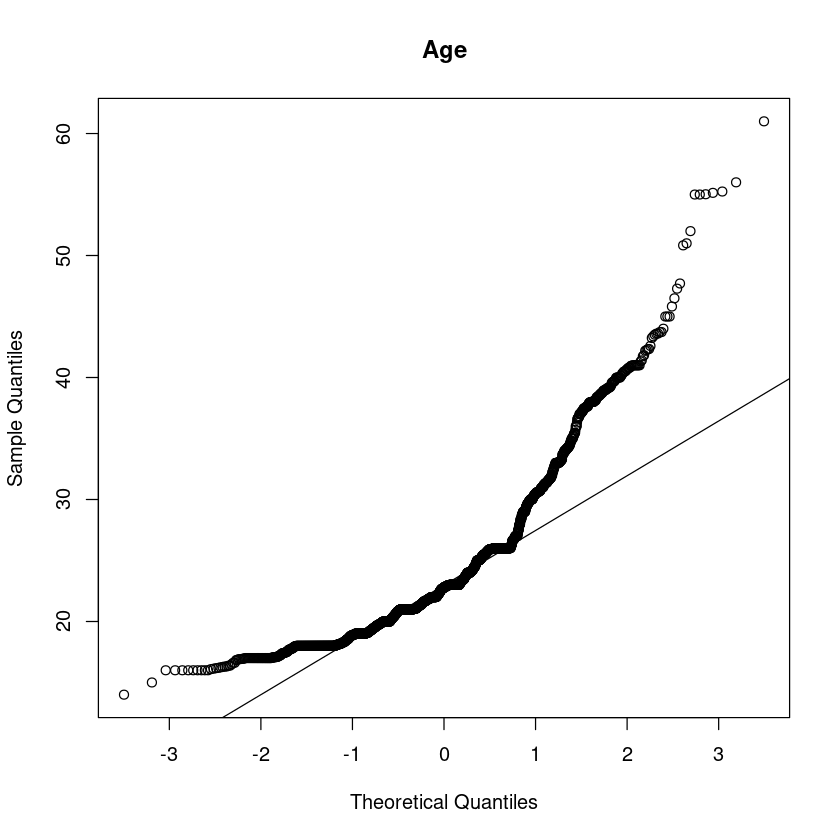

In [225]:
qqnorm(data_trimmed$Age, main='Age')
qqline(data_trimmed$Age)

## Height

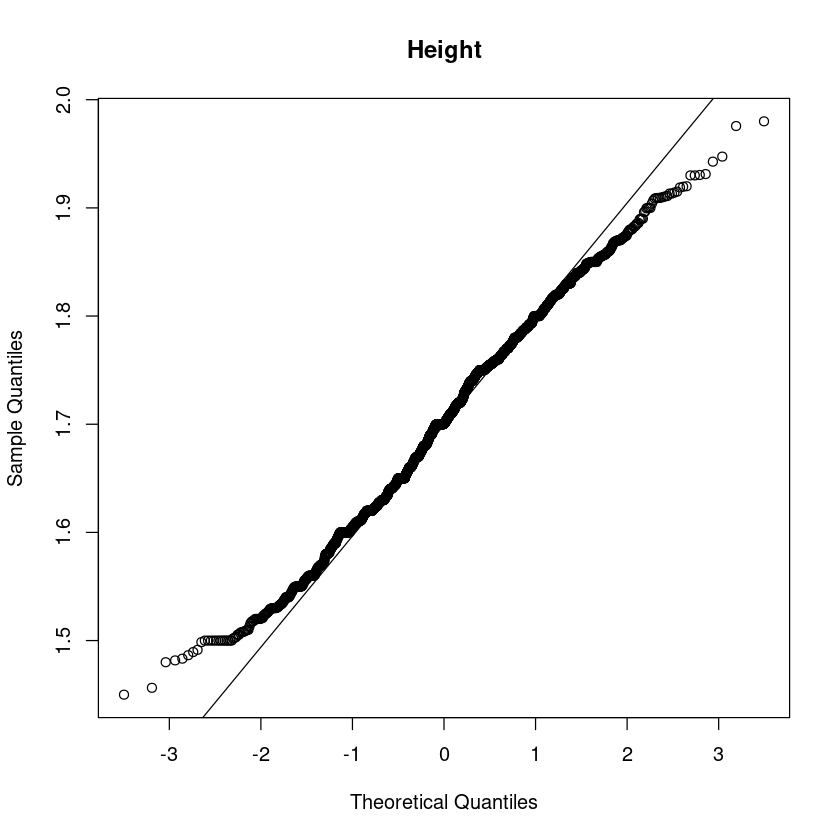

In [226]:
qqnorm(data_trimmed$Height, main='Height')
qqline(data_trimmed$Height)

## Weight

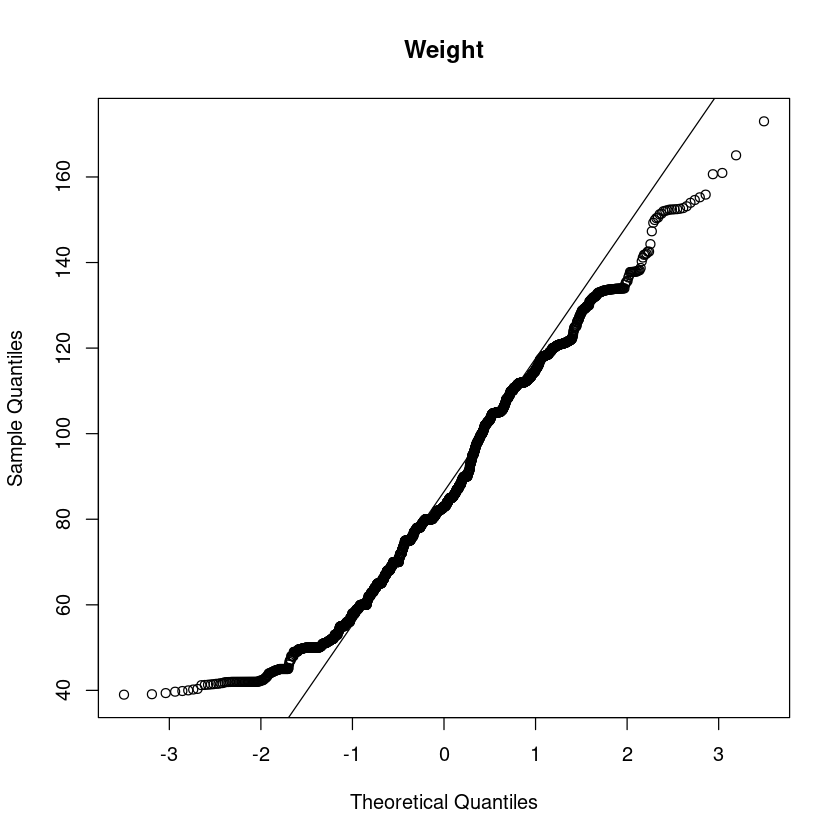

In [227]:
qqnorm(data_trimmed$Weight, main='Weight')
qqline(data_trimmed$Weight)

# Multivariate Statistics

# Let's check multivariate normality

Call: mardia(x = data_trimmed[, 1:8])

Mardia tests of multivariate skew and kurtosis
Use describe(x) the to get univariate tests
n.obs = 2111   num.vars =  8 
b1p =  8.81   skew =  3100.67  with probability  <=  0
 small sample skew =  3106.06  with probability <=  0
b2p =  79.4   kurtosis =  -1.08  with probability <=  0.28

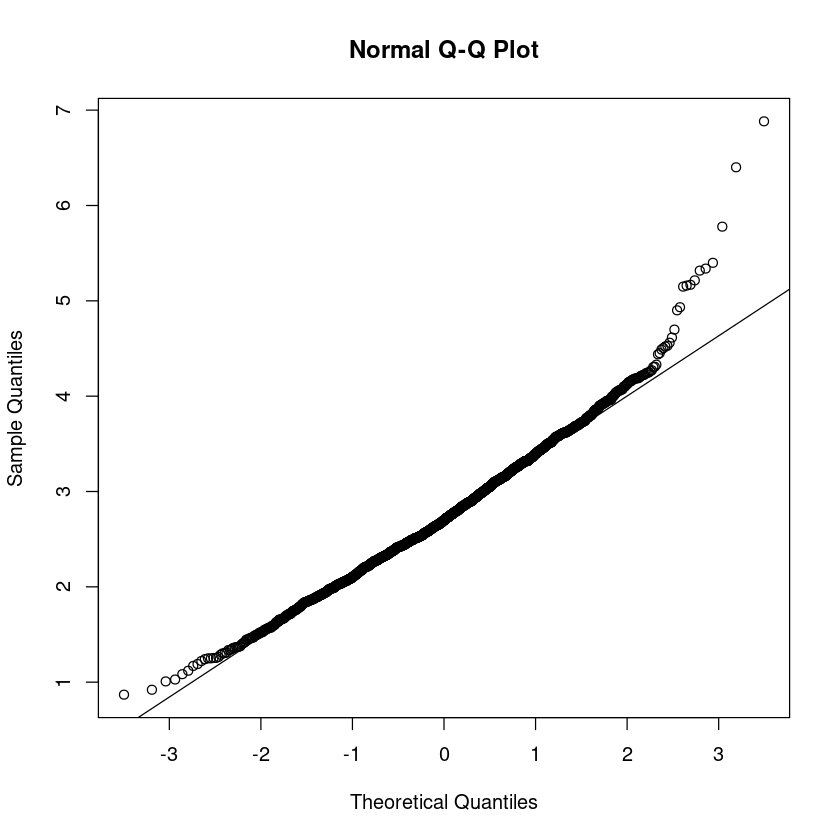

In [228]:
mardia(data_trimmed[,1:8])

<b>We see that the distribution of our dataset is not exactly multivariate normal, but it is close.</b>

## Let's play around with confidence intervals before we move on

<b>Let's check a 99% confidence region for the population mean vector of Height and Weight </b>

Height    Weight 
 1.701677 86.586058

,Height,Weight
Height,0.008705789,1.131795
Weight,1.131794703,685.977477


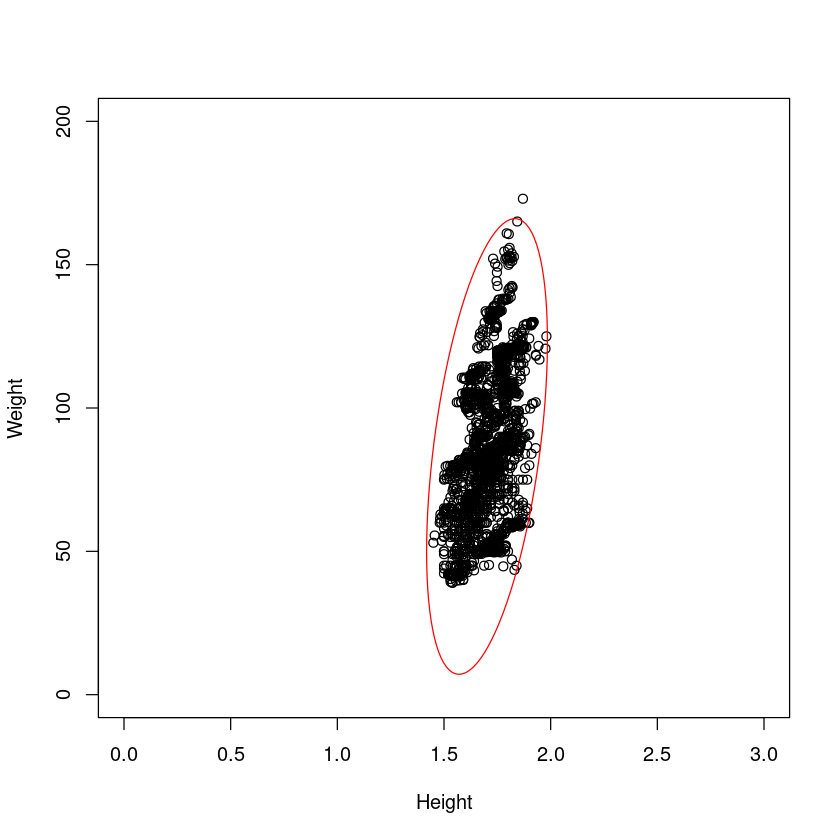

In [229]:
mean.vec <- colMeans(data_trimmed[,2:3])
mean.vec
vco.mat <- cov(data_trimmed[,2:3])
vco.mat
mu <- mean.vec
sigma0 <- vco.mat
x <- seq(0,10)
y <- seq(50, 100)

plot(data_trimmed[,2], data_trimmed[,3], xlim=c(0, 3), ylim=c(0,200), xlab='Height', ylab='Weight')
lines(ellipse(x=sigma0, center=mu, level = 0.99 ), col="red")

<b>It looks like only 1 observation falls outside our 99% confidence region.</b>

# Let's do some hypothesis testing

## Let's run a one-sample Hotelling's T2 test on our quantitative variables.

<b>First, let's compute the population mean vector</b>

In [230]:
mean.vec <- colMeans(data_trimmed[,1:8])
mean.vec

Age          Height          Weight      Vegetables           Meals 
     24.3125999       1.7016774      86.5860581       2.4190431       2.6856280 
    LitersWater   HoursExercise HoursTechnology 
      2.0080114       1.0102977       0.6578659

<b>Now, let's set a Mu0 with which we can run the test.</b>

In [231]:
mu <- c(30, 1.6, 88, 2.5, 2.8, 1.8, 1.2, 1)

<b>Let's now run the hotelling t test to check if our population mean vector differs from our null hypothesis.</b>

In [232]:
OneSampleHT2(data_trimmed[,1:8], mu=mu)

$HT2
         [,1]
[1,] 8164.056

$F
         [,1]
[1,] 1017.121

$df
[1]    8 2103

$p.value
     [,1]
[1,]    0

$CI
                     Lower      Upper  Mu0 Important Variables?
Age             23.7671757 24.8580241 30.0               *TRUE*
Height           1.6936580  1.7096967  1.6               *TRUE*
Weight          84.3349756 88.8371406 88.0                FALSE
Vegetables       2.3731531  2.4649331  2.5               *TRUE*
Meals            2.6187571  2.7524990  2.8               *TRUE*
LitersWater      1.9553292  2.0606936  1.8               *TRUE*
HoursExercise    0.9371909  1.0834045  1.2               *TRUE*
HoursTechnology  0.6055298  0.7102021  1.0               *TRUE*

$alpha
[1] 0.05

$Descriptive
              Age       Height     Weight   Vegetables        Meals
N     2111.000000 2.111000e+03 2111.00000 2111.0000000 2111.0000000
Means   24.312600 1.701677e+00   86.58606    2.4190431    2.6856280
Sd       6.345968 9.330482e-02   26.19117    0.5339266    0.7780386
       LitersWater HoursExercise HoursTechnology
N     2111.0000000  2111.0000000    2111.0000000
Means    2.0080114     1.0102977       0.6578659
Sd       0.6129535     0.8505924       0.6089273

$Test
[1] "OneSampleHT2"

attr(,"class")
[1] "MVTests" "list"

<b>Conclusion: Reject H0, there is sufficient evidence to suggest the population mean vector of our quantitative variables is different from <br>(30, 1.6, 88, 2.5, 2.8, 1.8, 1.2, 1)</b>

## Now let's run a Two sample t test to determine if the population mean vectors are different between two Obesity Levels: Obese and Average

<b>First, let's divide our data into two groups based on method of transportation.</b>

In [233]:
data_obese <- data_trimmed[data_trimmed$ObesityLevel == 'Obese',]
data_average <- data_trimmed[data_trimmed$ObesityLevel == 'Average',]

In [234]:
head(data_obese)
head(data_average)

,Age,Height,Weight,Vegetables,Meals,LitersWater,HoursExercise,HoursTechnology,MethodTransportation,ObesityLevel
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
11,26,1.85,105,3,3,3,2,2,Public_Transportation,Obese
14,41,1.80,99,2,3,2,2,1,Automobile,Obese
18,29,1.53,78,2,1,2,0,0,Automobile,Obese
22,52,1.69,87,3,1,2,0,0,Automobile,Obese
24,22,1.60,82,1,1,2,0,2,Public_Transportation,Obese
68,23,1.65,95,2,3,2,0,1,Automobile,Obese


,Age,Height,Weight,Vegetables,Meals,LitersWater,HoursExercise,HoursTechnology,MethodTransportation,ObesityLevel
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,21,1.62,64,2,3,2,0,1,Public_Transportation,Average
2,21,1.52,56,3,3,3,3,0,Public_Transportation,Average
3,23,1.80,77,2,3,2,2,1,Public_Transportation,Average
6,29,1.62,53,2,3,2,0,0,Automobile,Average
7,23,1.50,55,3,3,2,1,0,Motorbike,Average
8,22,1.64,53,2,3,2,3,0,Public_Transportation,Average


<b>Let's check multivariate normality</b>

In [235]:
?mardia

Call: mardia(x = data_obese[, 1:8])

Mardia tests of multivariate skew and kurtosis
Use describe(x) the to get univariate tests
n.obs = 972   num.vars =  8 
b1p =  15.28   skew =  2475.05  with probability  <=  0
 small sample skew =  2484.4  with probability <=  0
b2p =  85.46   kurtosis =  6.72  with probability <=  1.8e-11

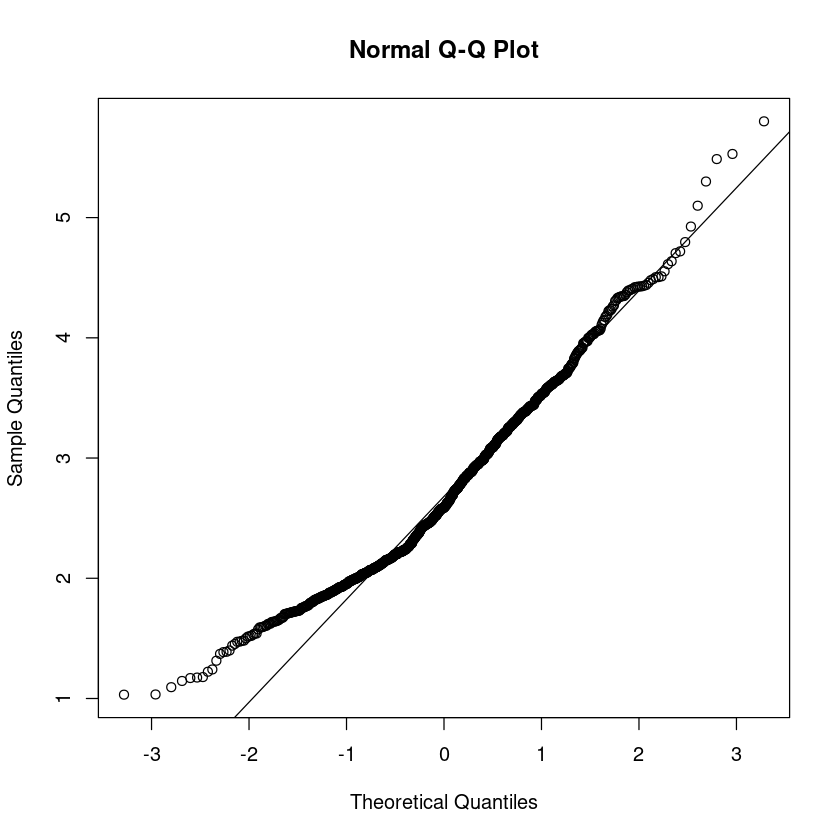

Call: mardia(x = data_average[, 1:8])

Mardia tests of multivariate skew and kurtosis
Use describe(x) the to get univariate tests
n.obs = 287   num.vars =  8 
b1p =  14.85   skew =  710.23  with probability  <=  1.5e-84
 small sample skew =  719.32  with probability <=  3.4e-86
b2p =  90.66   kurtosis =  7.14  with probability <=  9.2e-13

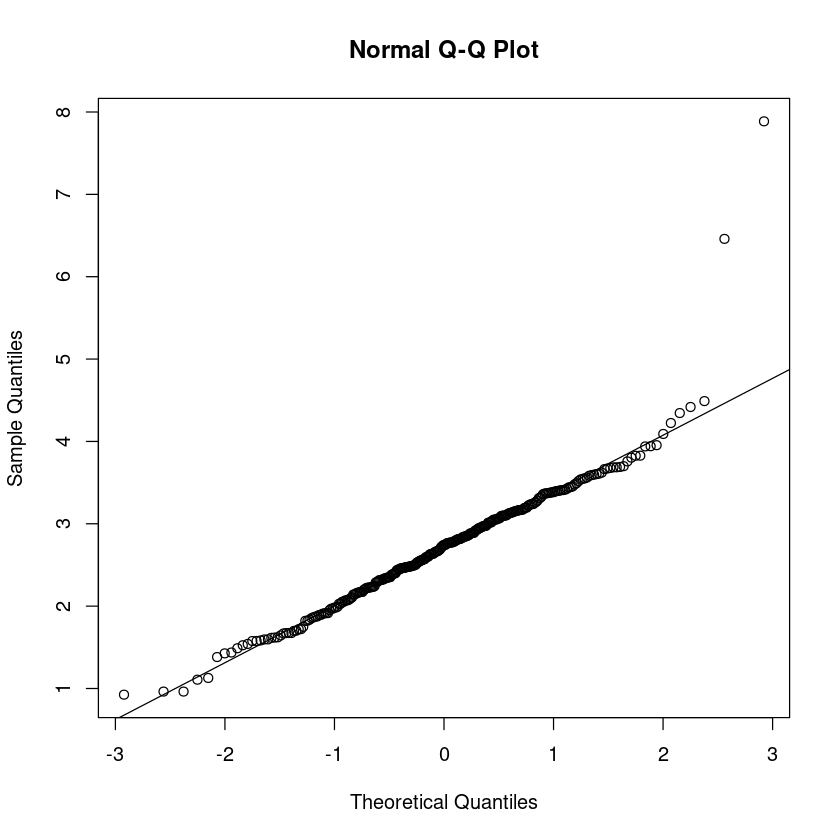

In [236]:
mardia(data_obese[,1:8])
mardia(data_average[,1:8])

<b>It seems that data for the Obese cases are from a multivariate normal distribution, but Average cases are slightly non-normal.</b>

In [237]:
data_ob_av <- data_trimmed[(data_trimmed$ObesityLevel == 'Average') | (data_trimmed$ObesityLevel == 'Obese'),]

In [238]:
index.s <- data_ob_av$ObesityLevel == 'Obese'
data_ob_av$grp = rep(1, length(index.s))
data_ob_av$grp[!index.s] = 2

<b>Null Hypothesis: The population mean vector of all quantitative variables is not different between Obesity Level of Obese and Average.</b>

In [239]:
TwoSamplesHT2(data_ob_av[,1:8], group=data_ob_av$grp)

$HT2
         [,1]
[1,] 4185.466

$F
         [,1]
[1,] 520.2698

$df
[1]    8 1250

$p.value
     [,1]
[1,]    0

$CI
                      Lower       Upper Important Variables?
Age              2.54124724  5.59376283               *TRUE*
Height           0.01497101  0.06296454               *TRUE*
Weight          42.70508512 51.14949785               *TRUE*
Vegetables       0.04434402  0.32682023               *TRUE*
Meals           -0.20389539  0.16011597                FALSE
LitersWater      0.05834526  0.38658363               *TRUE*
HoursExercise   -0.59369393 -0.15130404               *TRUE*
HoursTechnology -0.22707182  0.08183178                FALSE

$alpha
[1] 0.05

$Descriptive1
           Age     Height   Weight Vegetables     Meals LitersWater
Means 25.80618 1.71555314 109.0823  2.5200769 2.7167863   2.0726387
Sd     5.91898 0.08899515  17.3555  0.5125072 0.6189637   0.6111681
      HoursExercise HoursTechnology
Means     0.8748878       0.6033382
Sd        0.7696066       0.5461127

$Descriptive2
            Age     Height    Weight Vegetables     Meals LitersWater
Means 21.738676 1.67658537 62.155052  2.3344948 2.7386760   1.8501742
Sd     5.096756 0.09452594  9.296031  0.5909827 0.8718614   0.6383915
      HoursExercise HoursTechnology
Means      1.247387       0.6759582
Sd         1.016362       0.6866970

$Test
[1] "TwoSamplesHT2"

attr(,"class")
[1] "MVTests" "list"

<b>Conclusion: Reject null hypothesis, there is sufficient evidence to suggest the population mean vector of all quantiative variables is different between Obese and Average.</b>

# Let us now run a MANOVA to test whether the population mean vector depends on Method of Transporation

In [240]:
fit <- manova(cbind(Weight, Meals, LitersWater, HoursExercise, HoursTechnology)~MethodTransportation, data=data_trimmed[,-10])
summary(fit)

                       Df   Pillai approx F num Df den Df    Pr(>F)    
MethodTransportation    4 0.071993   7.7162     20   8420 < 2.2e-16 ***
Residuals            2106                                              
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [241]:
unique(data_trimmed$MethodTransportation)

[1] Public_Transportation Walking               Automobile           
[4] Motorbike             Bike                 
Levels: Automobile Bike Motorbike Public_Transportation Walking

<b>Conclusion: There is sufficient evidence to suggest that the population mean vector of our quantitative variables depends on method of transporation.</b>

Call: mardia(x = fit$residuals)

Mardia tests of multivariate skew and kurtosis
Use describe(x) the to get univariate tests
n.obs = 2111   num.vars =  5 
b1p =  2.94   skew =  1035.58  with probability  <=  9.8e-195
 small sample skew =  1037.54  with probability <=  3.8e-195
b2p =  32.36   kurtosis =  -7.26  with probability <=  3.9e-13

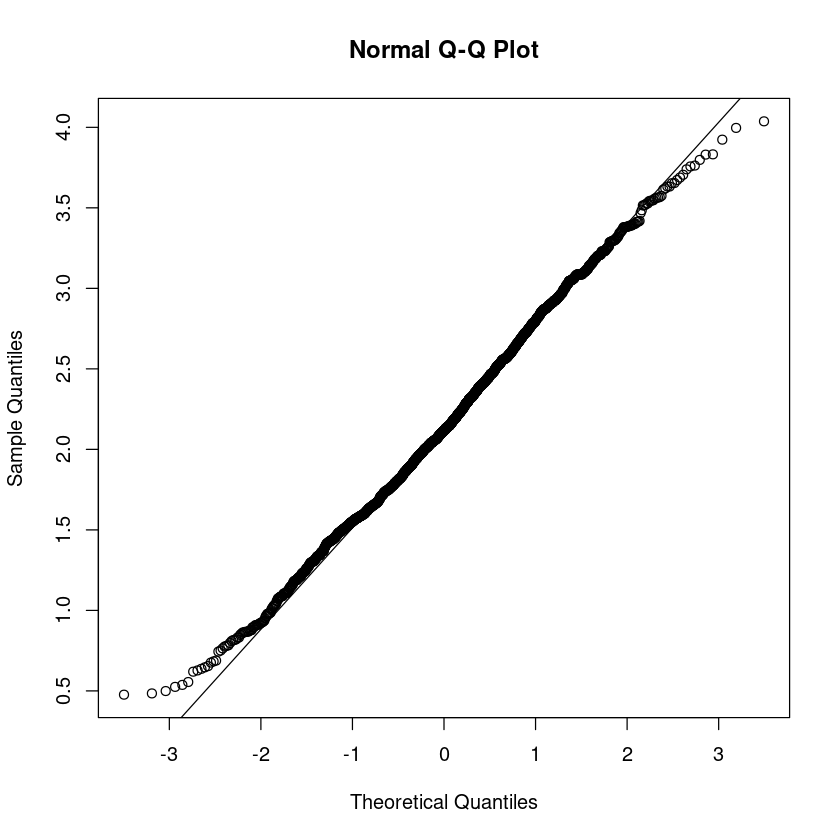

In [242]:
mardia(fit$residuals)

<b>We can see from a Q-Q plot of our residuals, that our population vector meets the normality assumption.</b>

<b>Let's also perform a BoxM test to check if the population covariance matrices are the same for each method of transporation.</b>

In [243]:
with(data_trimmed[,-10], BoxM(cbind(Weight, Meals, LitersWater, HoursExercise, HoursTechnology) , group = MethodTransportation ))

$Chisq
[1] Inf

$df
[1] 60

$p.value
[1] 0

$Test
[1] "BoxM"

attr(,"class")
[1] "MVTests" "list"

<b>Based on the results of our BoxM test, we conclude that the population covariance matrices are different for each method of transportation.</b>

# Let's try to build a Multinomial Naive Bayes Classifier

In [244]:
library(e1071)
library(caret)

In [245]:
set.seed(123)
train_index <- createDataPartition(data_trimmed$ObesityLevel, p=0.75, list=FALSE)
train_data <- data_trimmed[train_index, -10]
test_data <- data_trimmed[-train_index, -10]
train_labels <- data_trimmed[train_index, -c(1:9)]
test_labels <- data_trimmed[-train_index, -c(1:9)]

In [246]:
mnb_model <- naiveBayes(train_data, train_labels, laplace=1)

In [247]:
test_pred <- predict(mnb_model, test_data)

In [248]:
conf_matrix <- confusionMatrix(test_pred, test_labels)
print(conf_matrix)

Confusion Matrix and Statistics

             Reference
Prediction    Average Obese Overweight Underweight
  Average          25     1         19           5
  Obese             0   200         21           0
  Overweight       24    42        105           3
  Underweight      22     0          0          60

Overall Statistics
                                         
               Accuracy : 0.74           
                 95% CI : (0.7004, 0.777)
    No Information Rate : 0.4611         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6193         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: Average Class: Obese Class: Overweight
Sensitivity                 0.35211       0.8230            0.7241
Specificity                 0.94518       0.9261            0.8194
Pos Pred Value              0.50000       0.9050            0.6034


# Distances

<b>Let's visualize a distance matrix for our dataset</b>

In [249]:
Mat.dist = dist(data_trimmed[1:50,-c(9,10)])

In [250]:
Mat.dist = as.matrix(Mat.dist)

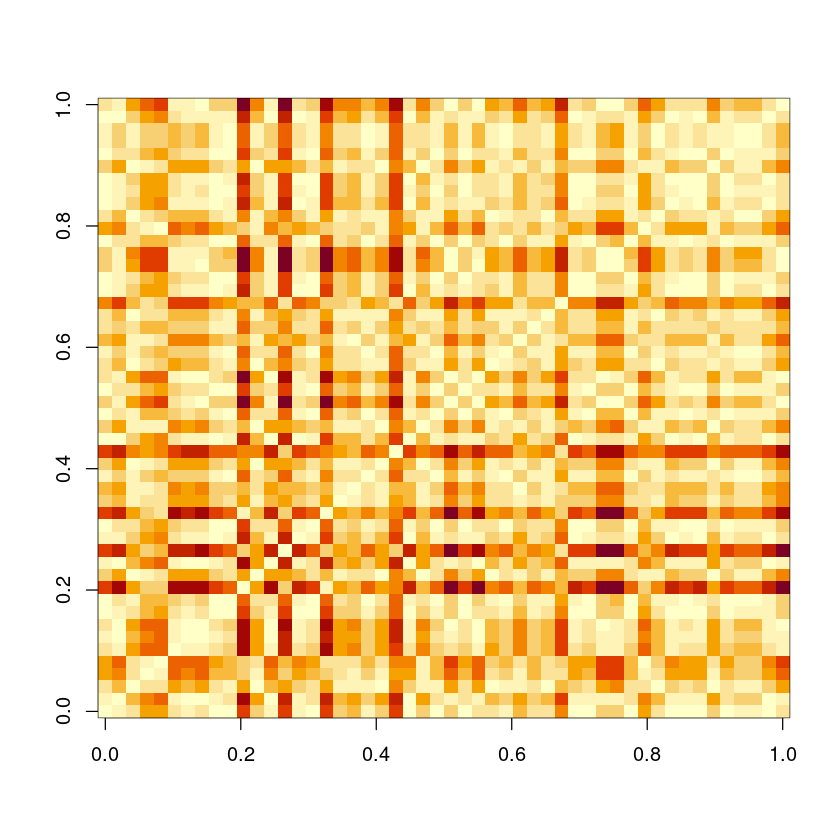

In [251]:
image(Mat.dist)

# Let's now perform a principle component analysis on our dataset

In [252]:
s.dat <- data_trimmed[,1:8] %>% mutate_all(scale)
fit.s <- prcomp(s.dat)
fit.s

Standard deviations (1, .., p=8):
[1] 1.3460640 1.2217330 1.0057986 0.9751474 0.9698597 0.8796460 0.8096728
[8] 0.6024633

Rotation (n x k) = (8 x 8):
                        PC1         PC2         PC3         PC4         PC5
Age             0.007592077 -0.60380242  0.33842822  0.13433682 -0.02619467
Height          0.598077487  0.07029488  0.29822751 -0.08281009 -0.06702024
Weight          0.503660859 -0.36177851  0.01121127 -0.39859007 -0.14173219
Vegetables      0.161967975 -0.26018670 -0.83080707 -0.06263861  0.30541293
Meals           0.333123415  0.12777839  0.18585624 -0.06800734  0.75089430
LitersWater     0.384654968  0.05299330 -0.26063746  0.21451928 -0.54105246
HoursExercise   0.321236420  0.36164717 -0.04050135  0.64782898  0.06927109
HoursTechnology 0.014639096  0.53101429 -0.04523084 -0.58478420 -0.14169884
                         PC6         PC7         PC8
Age             -0.005052067 -0.69118830  0.15598723
Height          -0.288908405  0.22315093  0.63545942
Weight

In [253]:
s.dat <- data_trimmed[,1:8] %>% mutate_all(scale)
fit.s <- prcomp(s.dat)
PC1 <- fit.s$rotation[,1]
round(PC1, 3)

Age          Height          Weight      Vegetables           Meals 
          0.008           0.598           0.504           0.162           0.333 
    LitersWater   HoursExercise HoursTechnology 
          0.385           0.321           0.015

<b>Our first principle component is as follows:</b>

<b>PC1 = (0.008)Age + (0.598)Height + (0.504)Weight + (0.162)Vegetables + (0.333)Meals+ (0.385)LitersWater + (0.321)HoursExercise + (0.015)HoursTechnology</b>

In [254]:
PC2 <- fit.s$rotation[,2]
round(PC2, 3)

Age          Height          Weight      Vegetables           Meals 
         -0.604           0.070          -0.362          -0.260           0.128 
    LitersWater   HoursExercise HoursTechnology 
          0.053           0.362           0.531

<b>The second principle component is as follows: </b>

<b>PC2 = -(0.604)Age + (0.07)Height - (0.362)Weight - (0.26)Vegetables + (0.128)Meals + (0.053)LitersWater + (0.362)HoursExercise + (0.531)HoursTechnology</b>

## Let's test a few methods for choosing the optimal number of components

<b>Method 1: Choosing components that explain at least 80% of the original variance</b>

In [255]:
prop_var <- (fit.s$sdev[1:6]^2)/sum((fit.s$sdev)^2)
sum(prop_var)

[1] 0.8726835

In [256]:
prop_var <- (fit.s$sdev[1]^2)/sum((fit.s$sdev)^2)
sum(prop_var)

[1] 0.226486

In [257]:
prop_var <- (fit.s$sdev[1:2]^2)/sum((fit.s$sdev)^2)
sum(prop_var)

[1] 0.413065

In [258]:
prop_var <- (fit.s$sdev[1:3]^2)/sum((fit.s$sdev)^2)
sum(prop_var)

[1] 0.5395188

In [259]:
prop_var <- (fit.s$sdev[1:4]^2)/sum((fit.s$sdev)^2)
sum(prop_var)

[1] 0.6583829

In [260]:
prop_var <- (fit.s$sdev[1:5]^2)/sum((fit.s$sdev)^2)
sum(prop_var)

[1] 0.7759614

In [261]:
prop_var <- (fit.s$sdev[1:6]^2)/sum((fit.s$sdev)^2)
sum(prop_var)

[1] 0.8726835

<b>Method 2: Selecting components based on eigenvalues</b>

In [262]:
mat <- cov(s.dat)
eigen(mat)$values

[1] 1.8118883 1.4926315 1.0116309 0.9509124 0.9406278 0.7737770 0.6555700
[8] 0.3629621

In [263]:
sum(eigen(mat)$values)

[1] 8

In [264]:
sum(eigen(mat)$values[1:6])

[1] 6.981468

In [265]:
sum(eigen(mat)$values[1:6]) / sum(eigen(mat)$values)

[1] 0.8726835

<b>We see that the total variance is: 8</b>

<b>Selecting 6 principle components will capture (6.98/8) = 87.26% of the variance</b>

<b>Method 3: Examining point of inflection in the scree plot</b>

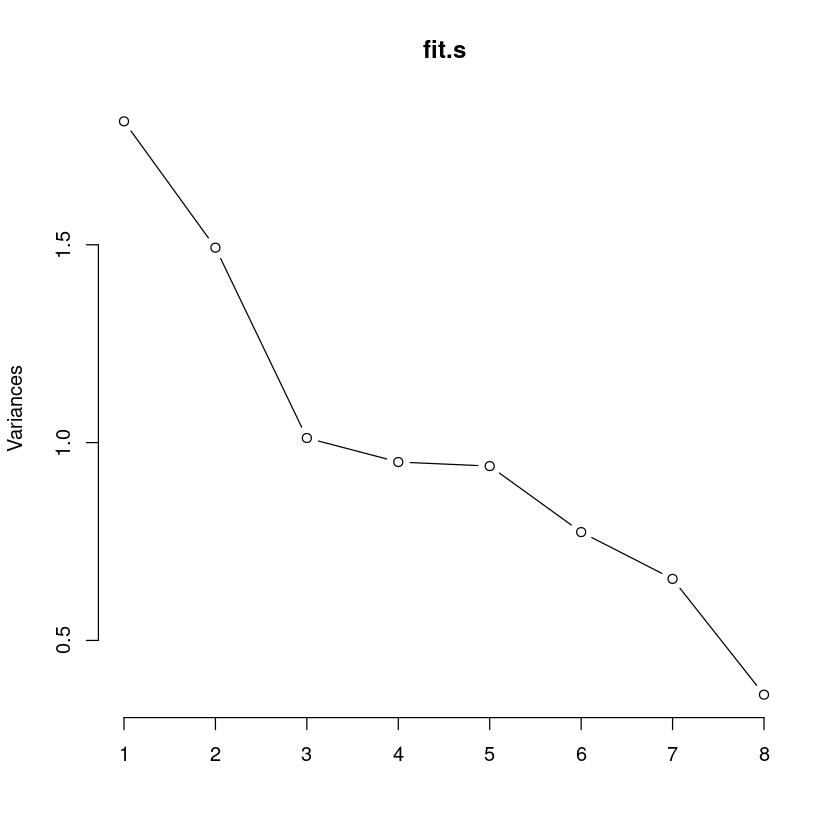

In [266]:
plot.pca <- plot(fit.s, type='l')

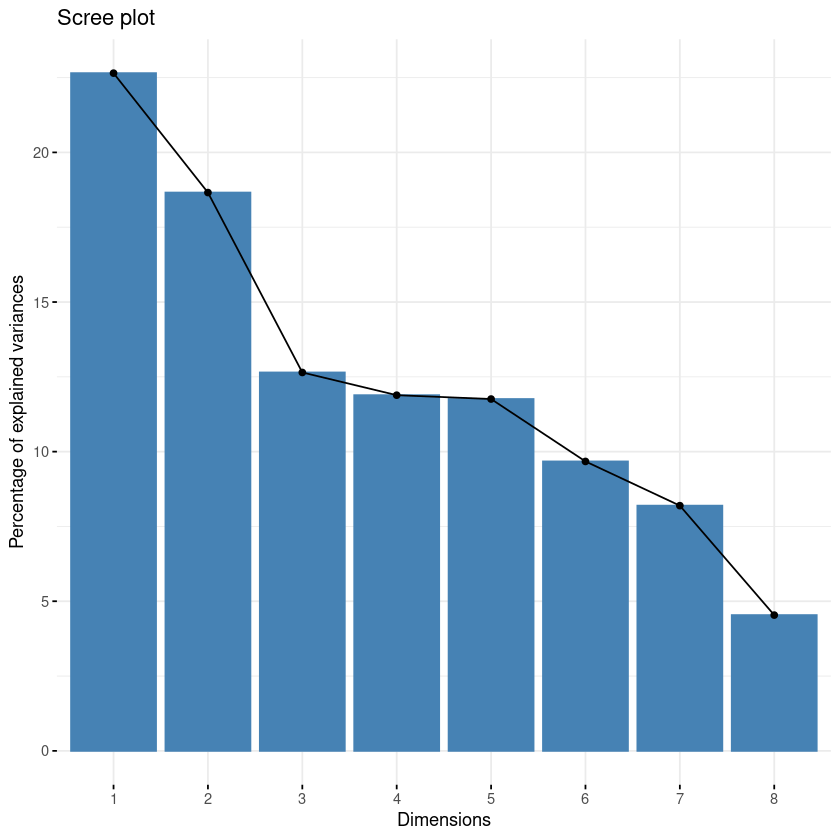

In [267]:
fviz_eig(fit.s)

<b>Wait a moment...We actually see two inflection points here, at PC3 and PC6. However, we should choose 6 principle components in order to capture at least 80% of the variance.</b>

<b>Now let's look at a biplot</b>

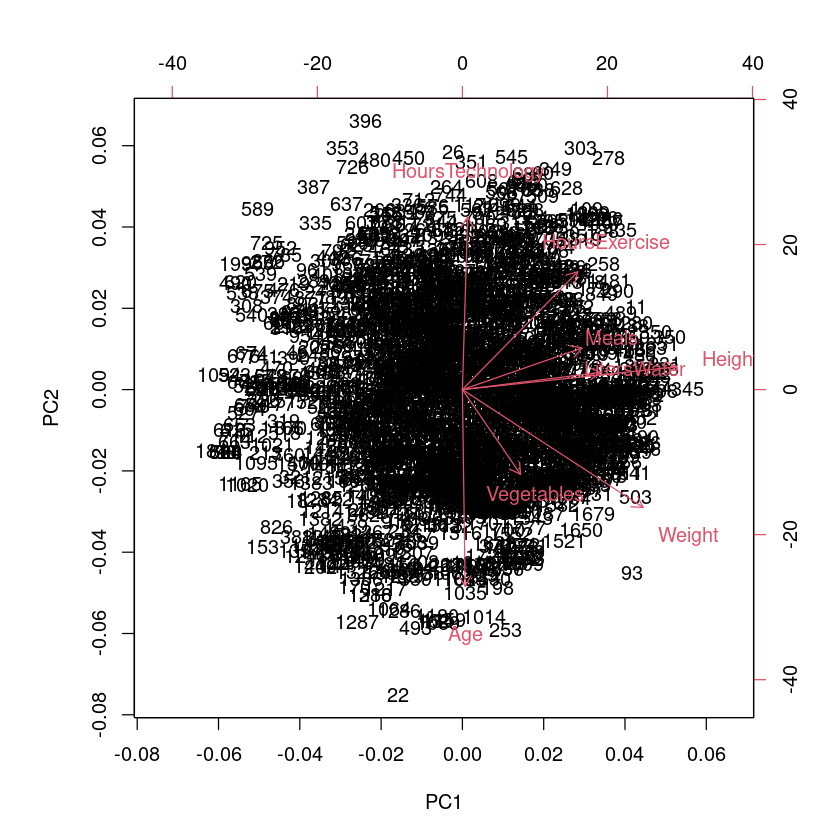

In [268]:
biplot(fit.s)

# Factor Analysis

In [269]:
fit.fa = factanal(~., s.dat, factors = 2, rotation='none', na.action=na.exclude)
fit.fa


Call:
factanal(x = ~., factors = 2, data = s.dat, na.action = na.exclude,     rotation = "none")

Uniquenesses:
            Age          Height          Weight      Vegetables           Meals 
          0.895           0.423           0.005           0.940           0.905 
    LitersWater   HoursExercise HoursTechnology 
          0.905           0.727           0.960 

Loadings:
                Factor1 Factor2
Age              0.202  -0.254 
Height           0.466   0.600 
Weight           0.997         
Vegetables       0.216  -0.116 
Meals            0.109   0.288 
LitersWater      0.202   0.232 
HoursExercise            0.520 
HoursTechnology          0.186 

               Factor1 Factor2
SS loadings       1.36   0.879
Proportion Var    0.17   0.110
Cumulative Var    0.17   0.280

Test of the hypothesis that 2 factors are sufficient.
The chi square statistic is 261.25 on 13 degrees of freedom.
The p-value is 2.93e-48 

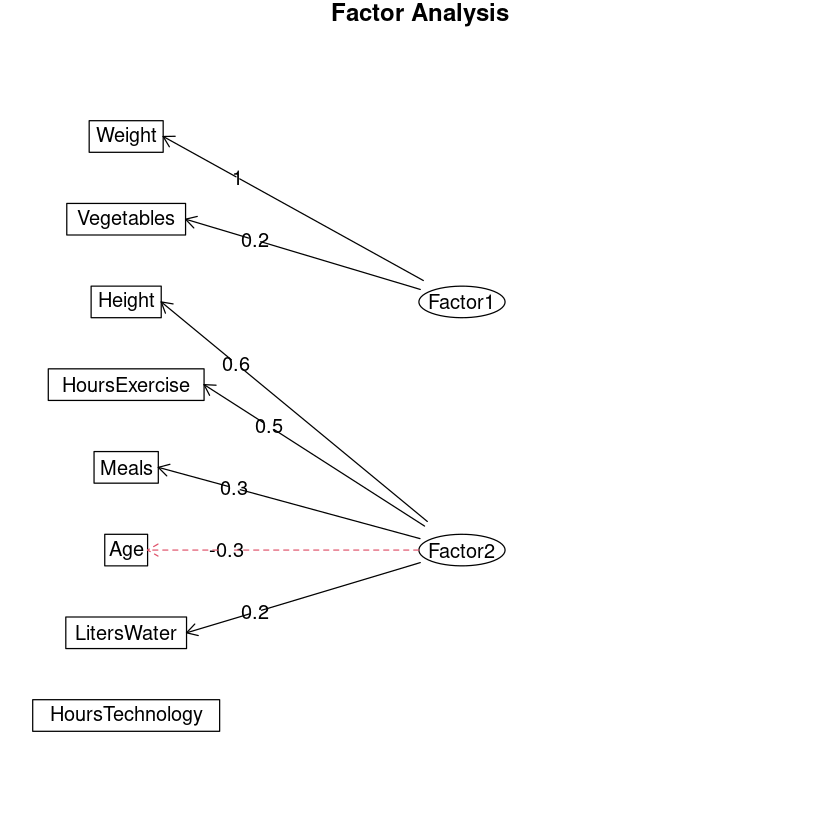

In [270]:
fa.diagram(fit.fa$loadings, cut=0.2)

<b>We see that our p-value rejects the null hypothesis that 2 factors are sufficient. Let's try 3.</b>


Call:
factanal(x = ~., factors = 3, data = s.dat, na.action = na.exclude,     rotation = "none")

Uniquenesses:
            Age          Height          Weight      Vegetables           Meals 
          0.005           0.191           0.005           0.925           0.924 
    LitersWater   HoursExercise HoursTechnology 
          0.927           0.819           0.907 

Loadings:
                Factor1 Factor2 Factor3
Age              0.769  -0.635         
Height           0.289   0.394   0.755 
Weight           0.778   0.624         
Vegetables       0.151   0.156  -0.168 
Meals                    0.123   0.243 
LitersWater      0.102   0.196   0.154 
HoursExercise   -0.124           0.399 
HoursTechnology -0.237   0.181         

               Factor1 Factor2 Factor3
SS loadings      1.387   1.065   0.845
Proportion Var   0.173   0.133   0.106
Cumulative Var   0.173   0.307   0.412

Test of the hypothesis that 3 factors are sufficient.
The chi square statistic is 89.32 on 7 degre

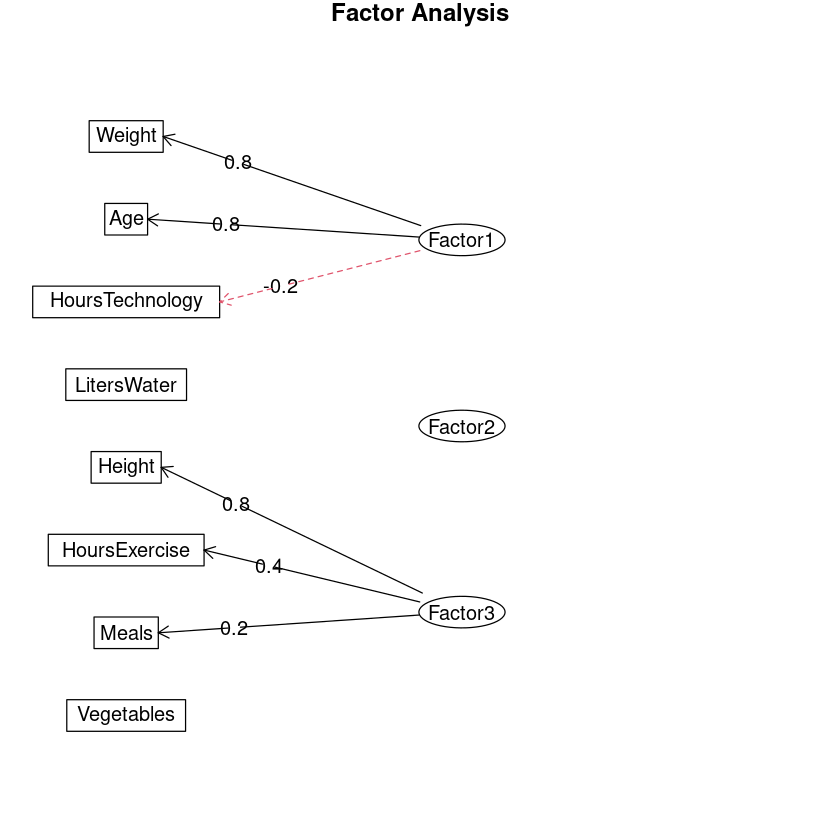

In [271]:
fit.fa = factanal(~., s.dat, factors = 3, rotation='none', na.action=na.exclude)
fit.fa
fa.diagram(fit.fa$loadings, cut=0.2)

<b>We see that our p-value rejects the null hypothesis that 3 factors are sufficient. Let's try 4.</b>


Call:
factanal(x = ~., factors = 4, data = s.dat, na.action = na.exclude,     rotation = "none")

Uniquenesses:
            Age          Height          Weight      Vegetables           Meals 
          0.819           0.005           0.005           0.872           0.924 
    LitersWater   HoursExercise HoursTechnology 
          0.863           0.693           0.005 

Loadings:
                Factor1 Factor2 Factor3 Factor4
Age              0.111  -0.316   0.147  -0.217 
Height           0.851   0.150  -0.498         
Weight           0.856  -0.106   0.501         
Vegetables       0.107  -0.127   0.221   0.228 
Meals            0.204          -0.122   0.125 
LitersWater      0.242                   0.278 
HoursExercise    0.141   0.107  -0.321   0.417 
HoursTechnology          0.988   0.130         

               Factor1 Factor2 Factor3 Factor4
SS loadings      1.603   1.142   0.704   0.365
Proportion Var   0.200   0.143   0.088   0.046
Cumulative Var   0.200   0.343   0.431   0

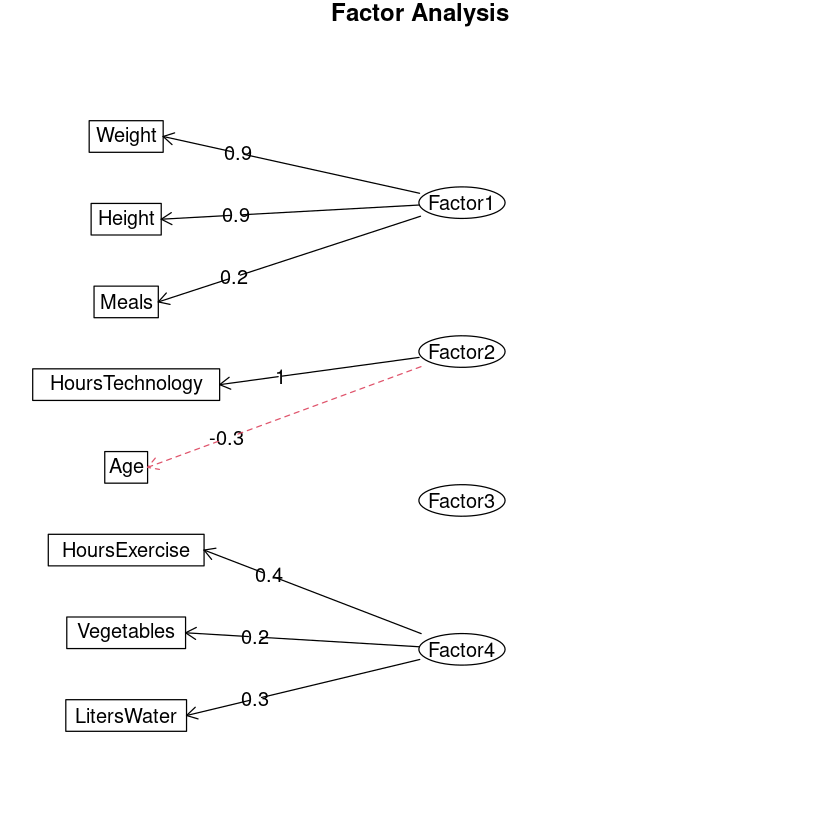

In [272]:
fit.fa = factanal(~., s.dat, factors = 4, rotation='none', na.action=na.exclude)
fit.fa
fa.diagram(fit.fa$loadings, cut=0.2)

<b>Wait a moment... what's going on?</b>

<b>Unfortunately, our p-value is not high enough to fail to reject the null hypothesis that 4 factors are sufficient, and 5 factors is too many for 8 variables. Thus, our factor model is not sufficient for our dataset.</b>

<b>Let us run a Kaiser-Meyer-Olkin (KMO) test to evaluate if our data is suitable for factor analysis.</b>

In [273]:
KMO(s.dat)

Kaiser-Meyer-Olkin factor adequacy
Call: KMO(r = s.dat)
Overall MSA =  0.49
MSA for each item = 
            Age          Height          Weight      Vegetables           Meals 
           0.52            0.48            0.45            0.33            0.70 
    LitersWater   HoursExercise HoursTechnology 
           0.72            0.45            0.55 

<b>Because our MSA is 0.49, we conclude that our dataset is unsuitable for a factor analysis.</b>

<b>Why is this? Let us run a Barlett's test for sphericity to see what's going on.</b>

In [274]:
cortest.bartlett(s.dat)

R was not square, finding R from data



$chisq
[1] 1679.398

$p.value
[1] 0

$df
[1] 28

<b>According to the Bartlett test, our data should be sufficiently correlated for Factor Analysis, however, we see that is failed. This might be due to our data failing to meet multivariate normality.</b>

In [275]:
fit.fatana = factanal(~., data=s.dat, factors=4, rotation='varimax', na.action=na.exclude)
fit.fatana


Call:
factanal(x = ~., factors = 4, data = s.dat, na.action = na.exclude,     rotation = "varimax")

Uniquenesses:
            Age          Height          Weight      Vegetables           Meals 
          0.819           0.005           0.005           0.872           0.924 
    LitersWater   HoursExercise HoursTechnology 
          0.863           0.693           0.005 

Loadings:
                Factor1 Factor2 Factor3 Factor4
Age                     -0.281   0.307         
Height           0.969           0.205  -0.121 
Weight           0.383           0.757   0.525 
Vegetables                               0.350 
Meals            0.265                         
LitersWater      0.261                   0.256 
HoursExercise    0.397          -0.362   0.133 
HoursTechnology          0.989          -0.111 

               Factor1 Factor2 Factor3 Factor4
SS loadings      1.390   1.065   0.847   0.512
Proportion Var   0.174   0.133   0.106   0.064
Cumulative Var   0.174   0.307   0.413 

Warning message in fa.parallel(x = cor1, fm = "minres", fa = "fa"):
“It seems as if you are using a correlation matrix, but have not specified the number of cases. The number of subjects is arbitrarily set to be 100  ”


Parallel analysis suggests that the number of factors =  2  and the number of components =  NA 


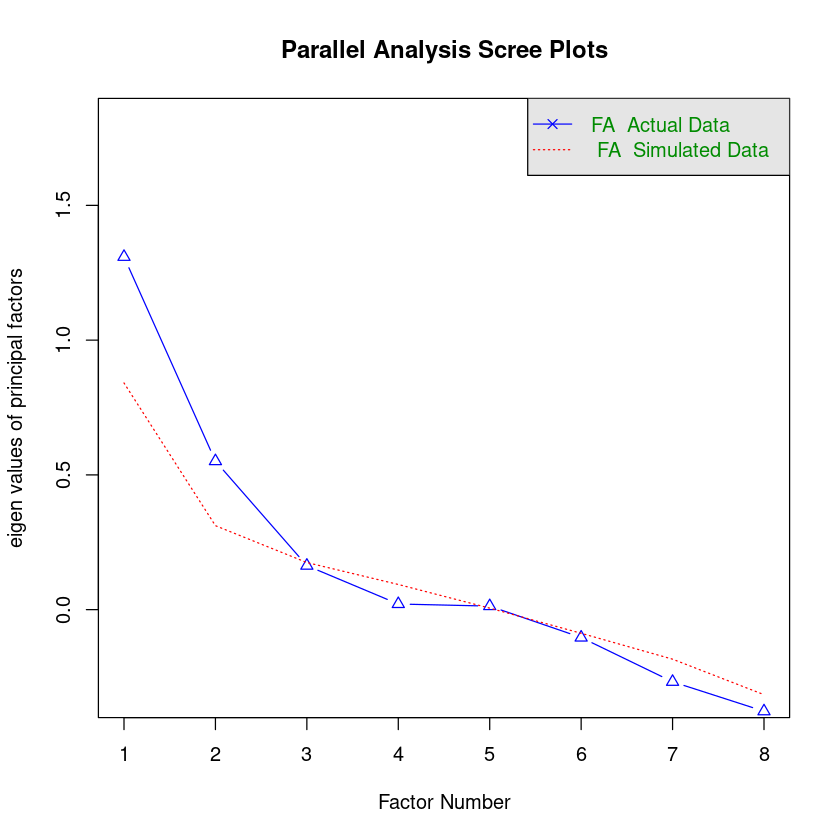

In [276]:
cor1 = cor(s.dat, use='pairwise.complete.obs')
fa.parallel(x=cor1, fm='minres', fa='fa')


Call:
factanal(x = ~., factors = 2, data = s.dat, na.action = na.exclude,     rotation = "varimax")

Uniquenesses:
            Age          Height          Weight      Vegetables           Meals 
          0.895           0.423           0.005           0.940           0.905 
    LitersWater   HoursExercise HoursTechnology 
          0.905           0.727           0.960 

Loadings:
                Factor1 Factor2
Age                      0.313 
Height           0.759         
Weight           0.586   0.808 
Vegetables               0.243 
Meals            0.297         
LitersWater      0.307         
HoursExercise    0.391  -0.347 
HoursTechnology  0.108  -0.168 

               Factor1 Factor2
SS loadings      1.274   0.965
Proportion Var   0.159   0.121
Cumulative Var   0.159   0.280

Test of the hypothesis that 2 factors are sufficient.
The chi square statistic is 261.25 on 13 degrees of freedom.
The p-value is 2.93e-48 

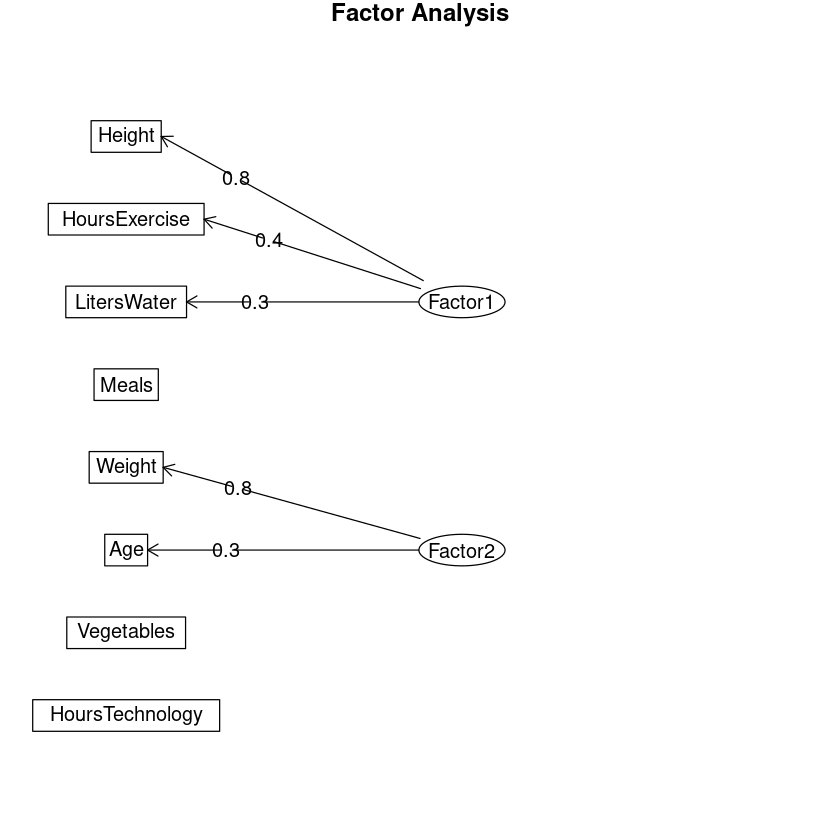

In [301]:
fit.fa3 = factanal(~., data=s.dat, factors=2, rotation='varimax', na.action=na.exclude)
fit.fa3

fa.diagram(fit.fa3$loadings)

<b>For Factor 1, only Height has a high positive loading of 0.759.</b>

<b>For Factor 2, only Weight has a high positive loading of 0.808.</b>

<b>The reason that these are the two primary factors associated with Obesity can be the fact that obesity is primarily calculated as BMI, which is the ratio of height vs. weight.</b>

<b>Let's calculate the communality of our variables.</b>

In [303]:
fit.fa3$loadings


Loadings:
                Factor1 Factor2
Age                      0.313 
Height           0.759         
Weight           0.586   0.808 
Vegetables               0.243 
Meals            0.297         
LitersWater      0.307         
HoursExercise    0.391  -0.347 
HoursTechnology  0.108  -0.168 

               Factor1 Factor2
SS loadings      1.274   0.965
Proportion Var   0.159   0.121
Cumulative Var   0.159   0.280

In [307]:
cm.weight <- c(0.586,0.808)
sum(cm.weight^2)

[1] 0.99626

In [305]:
cm.height <- c(0.759)
sum(cm.height^2)

[1] 0.576081

In [311]:
cm.exercise <- c(0.391,-0.347)
sum(cm.exercise^2)

[1] 0.27329

In [304]:
cm.age <- c(0.313)
sum(cm.age^2)

[1] 0.097969

In [310]:
cm.water <- c(0.307)
sum(cm.water^2)

[1] 0.094249

In [309]:
cm.meals <- c(0.297)
sum(cm.meals^2)

[1] 0.088209

In [308]:
cm.veg <- c(0.243)
sum(cm.veg^2)

[1] 0.059049

In [312]:
cm.tech <- c(0.108 ,-0.168 )
sum(cm.tech^2)

[1] 0.039888

# Discriminant Analysis

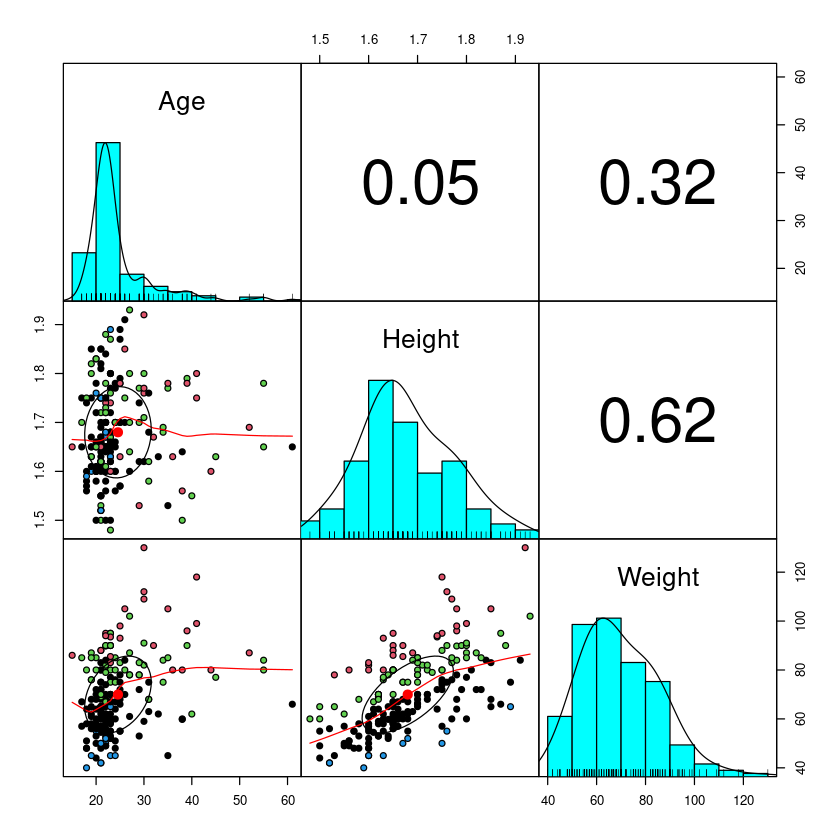

In [278]:
pairs.panels(data_trimmed[1:200,1:3],
            gap=0,
            bg=data_trimmed$ObesityLevel,
            pch=21)

<b>We do see some seperability from our panels plot. Let's run an LDA and see what we find.</b>

<b>LDA with all variables</b>

In [320]:
fit <- lda(ObesityLevel~., data=data_trimmed[,-9])
fit

Call:
lda(ObesityLevel ~ ., data = data_trimmed[, -9])

Prior probabilities of groups:
    Average       Obese  Overweight Underweight 
  0.1359545   0.4604453   0.2747513   0.1288489 

Group means:
                 Age   Height    Weight Vegetables    Meals LitersWater
Average     21.73868 1.676585  62.15505   2.334495 2.738676    1.850174
Obese       25.80618 1.715553 109.08234   2.520077 2.716786    2.072639
Overweight  25.20733 1.695792  78.17605   2.262605 2.499874    2.041929
Underweight 19.78324 1.691117  49.90633   2.480788 2.914403    1.871281
            HoursExercise HoursTechnology
Average         1.2473868       0.6759582
Obese           0.8748878       0.6033382
Overweight      1.0074341       0.6551335
Underweight     1.2501313       0.8394591

Coefficients of linear discriminants:
                         LD1          LD2         LD3
Age              0.042972704  0.086254834  0.05409351
Height          -9.919441894  0.316832961  8.61167656
Weight           0.110253285 -

In [324]:
p.result1 = predict(fit, data_trimmed[,-9])
tab = table(Predicted = p.result1$class, Observed=data_trimmed$ObesityLevel)
tab
sum(diag(tab))/sum(tab)

             Observed
Predicted     Average Obese Overweight Underweight
  Average         165     0         33          56
  Obese             0   884          3           0
  Overweight       74    88        544           0
  Underweight      48     0          0         216

[1] 0.8569398

<b>LDA with selected variables</b>

In [326]:
fit <- lda(ObesityLevel~Age+Height+Weight+HoursExercise+LitersWater, data=data_trimmed[,-9])
fit

Call:
lda(ObesityLevel ~ Age + Height + Weight + HoursExercise + LitersWater, 
    data = data_trimmed[, -9])

Prior probabilities of groups:
    Average       Obese  Overweight Underweight 
  0.1359545   0.4604453   0.2747513   0.1288489 

Group means:
                 Age   Height    Weight HoursExercise LitersWater
Average     21.73868 1.676585  62.15505     1.2473868    1.850174
Obese       25.80618 1.715553 109.08234     0.8748878    2.072639
Overweight  25.20733 1.695792  78.17605     1.0074341    2.041929
Underweight 19.78324 1.691117  49.90633     1.2501313    1.871281

Coefficients of linear discriminants:
                      LD1         LD2         LD3
Age            0.04184813 -0.14639440 -0.04266054
Height        -8.98728369 -1.60140289 10.08043844
Weight         0.10094013  0.01810887 -0.00923772
HoursExercise -0.05651066  0.26651359 -0.83102490
LitersWater    0.02352771 -0.78609260  0.51050844

Proportion of trace:
   LD1    LD2    LD3 
0.9913 0.0070 0.0016 

In [327]:
p.result = predict(fit, data_trimmed[,-9])
tab = table(Predicted = p.result$class, Observed=data_trimmed$ObesityLevel)
tab
sum(diag(tab))/sum(tab)

             Observed
Predicted     Average Obese Overweight Underweight
  Average         175     0          6          38
  Obese             0   844          1           0
  Overweight       81   128        573           1
  Underweight      31     0          0         233

[1] 0.8645192

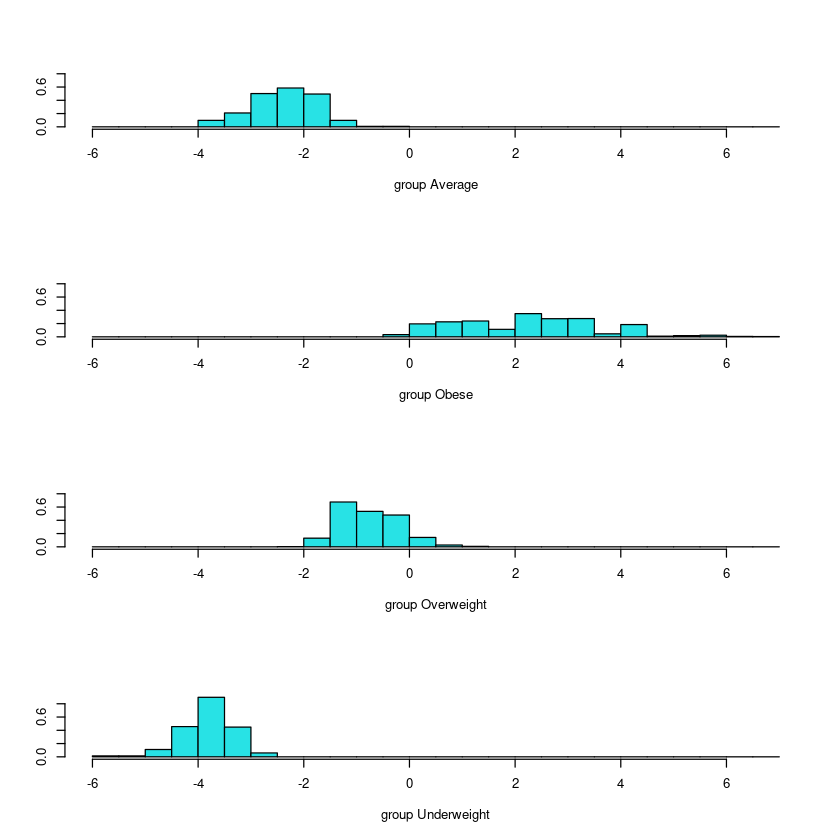

In [281]:
ldahist(data=p.result$x[,1], g=data_trimmed$ObesityLevel)

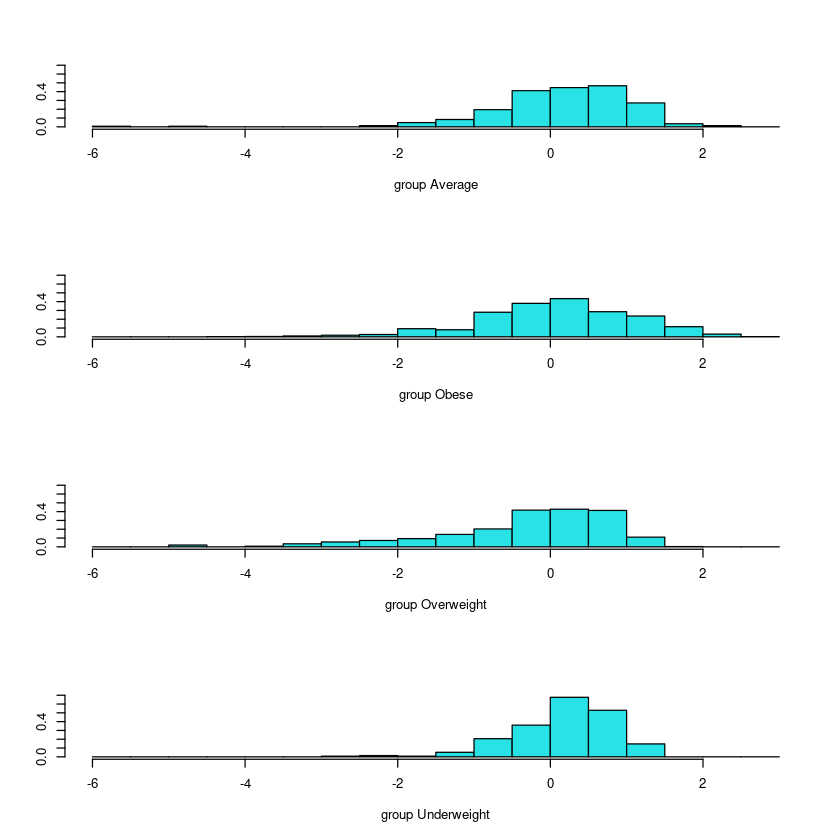

In [282]:
ldahist(data=p.result$x[,2], g=data_trimmed$ObesityLevel)

<b>Partition Plot</b>

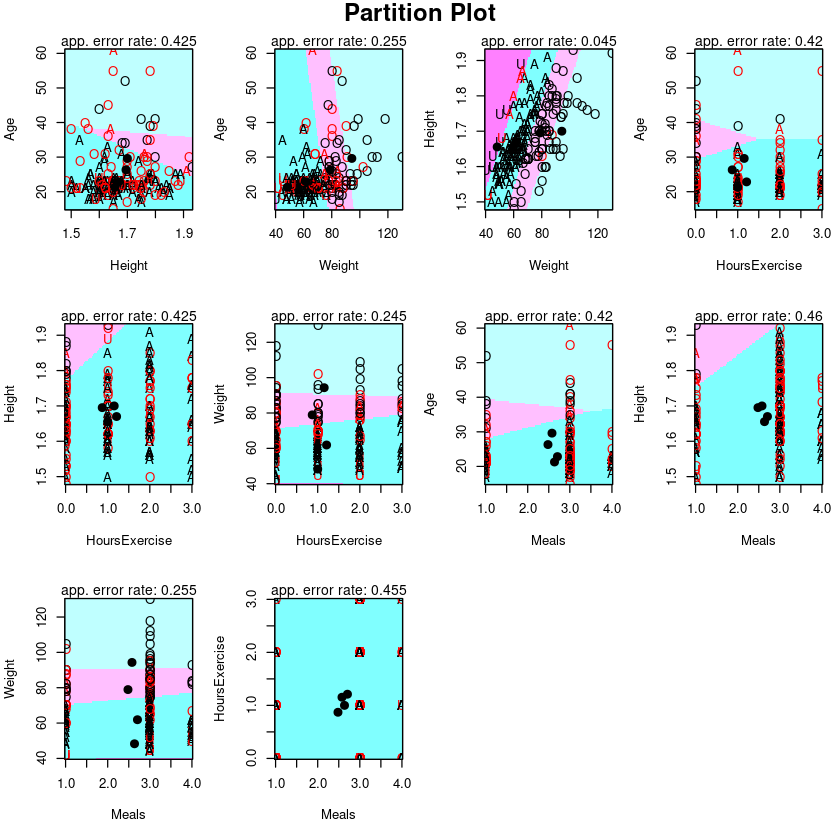

In [283]:
partimat(ObesityLevel~Age+Height+Weight+HoursExercise+Meals, data=data_trimmed[1:200,-9], method='lda')

<b>Quadratic Discriminant Analysis</b>

In [284]:
fit.q <- qda(ObesityLevel~Age+Height+Weight+HoursExercise+LitersWater, data=data_trimmed[,-9])
fit.q

Call:
qda(ObesityLevel ~ Age + Height + Weight + HoursExercise + LitersWater, 
    data = data_trimmed[, -9])

Prior probabilities of groups:
    Average       Obese  Overweight Underweight 
  0.1359545   0.4604453   0.2747513   0.1288489 

Group means:
                 Age   Height    Weight HoursExercise LitersWater
Average     21.73868 1.676585  62.15505     1.2473868    1.850174
Obese       25.80618 1.715553 109.08234     0.8748878    2.072639
Overweight  25.20733 1.695792  78.17605     1.0074341    2.041929
Underweight 19.78324 1.691117  49.90633     1.2501313    1.871281

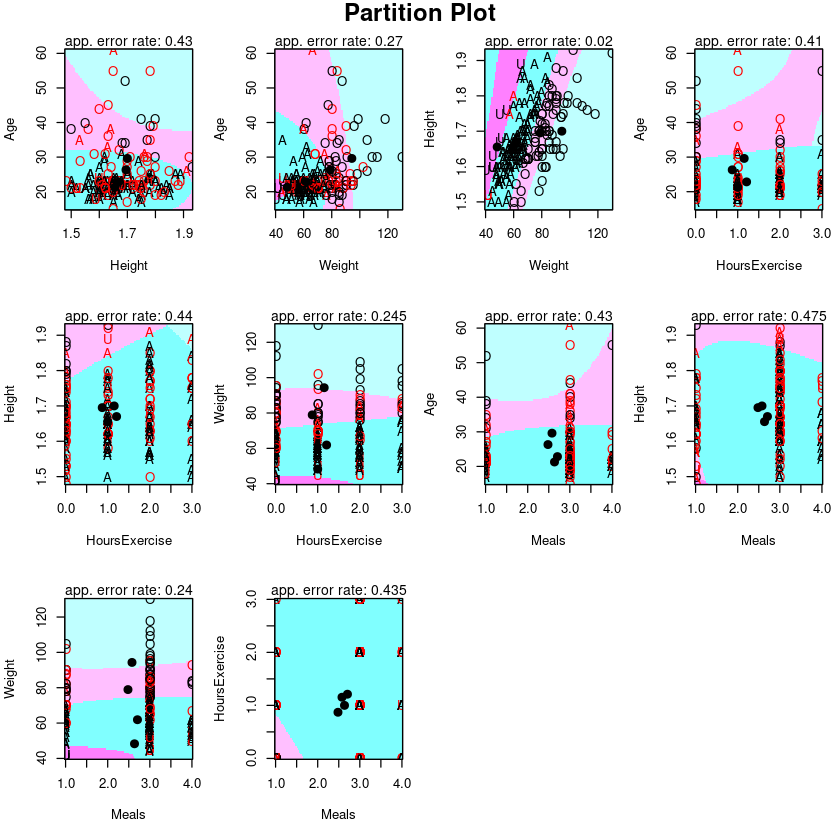

In [285]:
partimat(ObesityLevel~Age+Height+Weight+HoursExercise+Meals, data=data_trimmed[1:200,-9], method='qda')

<b>Let's test our models' predictive capabilities</b>

<b>LDA Prediction</b>

In [286]:
result.class = predict(fit, data_trimmed)$class
tab = table(Predicted = result.class, Observed=data_trimmed$ObesityLevel)
tab
sum(diag(tab))/sum(tab)

             Observed
Predicted     Average Obese Overweight Underweight
  Average         175     0          6          38
  Obese             0   844          1           0
  Overweight       81   128        573           1
  Underweight      31     0          0         233

[1] 0.8645192

<b>QDA Prediction</b>

In [287]:
result.class = predict(fit.q, data_trimmed)$class

In [288]:
tab2 = table(Predicted = result.class, Observed=data_trimmed$ObesityLevel)

In [289]:
tab2

             Observed
Predicted     Average Obese Overweight Underweight
  Average         245     0          2           3
  Obese             1   967          6           1
  Overweight       20     5        572           0
  Underweight      21     0          0         268

In [290]:
sum(diag(tab2))/sum(tab2)

[1] 0.9720512

<b>Our LDA had a prediction accuracy of 0.856, compared with our QDA prediction accuracy of 0.973</b>

<b>This is a very significant difference, suggesting our data is far more suitable for QDA and LDA.</b>

<b>Let's compare our QDA model with another model which can predict a classifier with multiple classes: Naive Bayes</b>

In [292]:
mnb_model <- naiveBayes(data_trimmed[,c('Age', 'Height', 'Weight', 'HoursExercise', 'Meals')], data_trimmed$ObesityLevel, laplace=1)

In [293]:
test_pred <- predict(mnb_model, data_trimmed[,c('Age','Height','Weight','HoursExercise','Meals')])
conf_matrix <- confusionMatrix(test_pred, data_trimmed$ObesityLevel)
print(conf_matrix)

Confusion Matrix and Statistics

             Reference
Prediction    Average Obese Overweight Underweight
  Average         116     0         83          14
  Obese             0   819         77           0
  Overweight       82   153        413           1
  Underweight      89     0          7         257

Overall Statistics
                                          
               Accuracy : 0.7603          
                 95% CI : (0.7415, 0.7784)
    No Information Rate : 0.4604          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.65            
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Average Class: Obese Class: Overweight
Sensitivity                 0.40418       0.8426            0.7121
Specificity                 0.94682       0.9324            0.8459
Pos Pred Value              0.54460       0.9141          

<b>We see that our Naive Baye's Model has an accuracy score of 0.7603, which is significantly worse when compared to both LDA and QDA.</b>

<b>Based on our Dimensionality Reduction techniques, we have decided to use Age, Height, Weight, HoursExercise, and LitersWater as our variables for our models. Let's check the multivariate normality assumption first.</b>

Call: mardia(x = data_trimmed[, c("Age", "Height", "Weight", "HoursExercise", 
    "LitersWater")])

Mardia tests of multivariate skew and kurtosis
Use describe(x) the to get univariate tests
n.obs = 2111   num.vars =  5 
b1p =  4.27   skew =  1502.01  with probability  <=  2.3e-293
 small sample skew =  1504.86  with probability <=  5.8e-294
b2p =  35.17   kurtosis =  0.45  with probability <=  0.65

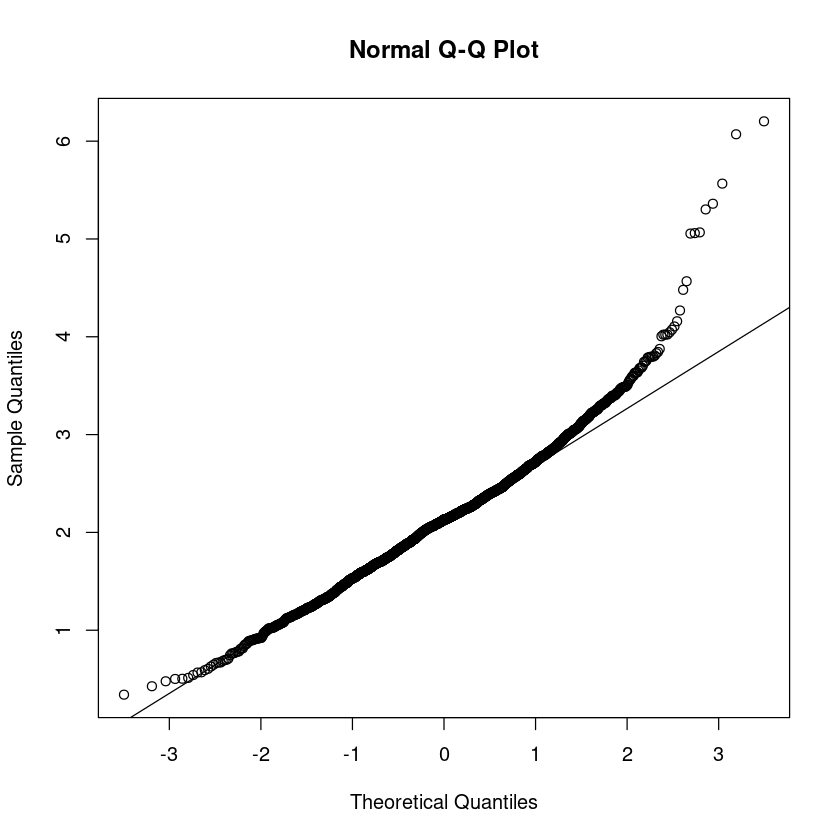

In [294]:
mardia(data_trimmed[,c('Age', 'Height', 'Weight', 'HoursExercise', 'LitersWater')])

<b>We see that our dataset containing these variables is close to multivariate normal and should be suitable for LDA and QDA.</b>

In [295]:
fit.lda <- lda(ObesityLevel~Age+Height+Weight+HoursExercise+LitersWater, data=data_trimmed[,-9])

In [296]:
result.class = predict(fit.lda, data_trimmed)$class
tab = table(Predicted = result.class, Observed=data_trimmed$ObesityLevel)
tab
paste('Accuracy: ', sum(diag(tab))/sum(tab))

             Observed
Predicted     Average Obese Overweight Underweight
  Average         175     0          6          38
  Obese             0   844          1           0
  Overweight       81   128        573           1
  Underweight      31     0          0         233

[1] "Accuracy:  0.864519185220275"

In [297]:
fit.qda <- qda(ObesityLevel~Age+Height+Weight+HoursExercise+LitersWater, data=data_trimmed[,-9])

In [298]:
result.class = predict(fit.qda, data_trimmed)$class
tab = table(Predicted = result.class, Observed=data_trimmed$ObesityLevel)
tab
paste('Accuracy: ', sum(diag(tab))/sum(tab))

             Observed
Predicted     Average Obese Overweight Underweight
  Average         245     0          2           3
  Obese             1   967          6           1
  Overweight       20     5        572           0
  Underweight      21     0          0         268

[1] "Accuracy:  0.972051160587399"

In [299]:
mnb_model <- naiveBayes(data_trimmed[,c('Age', 'Height', 'Weight', 'HoursExercise', 'LitersWater')], 
                        data_trimmed$ObesityLevel, laplace=1)

In [300]:
test_pred <- predict(mnb_model, data_trimmed[,c('Age','Height','Weight','HoursExercise','LitersWater')])
conf_matrix <- confusionMatrix(test_pred, data_trimmed$ObesityLevel)
print(conf_matrix)

Confusion Matrix and Statistics

             Reference
Prediction    Average Obese Overweight Underweight
  Average         118     0         74          13
  Obese             0   816         73           0
  Overweight       82   156        426           2
  Underweight      87     0          7         257

Overall Statistics
                                          
               Accuracy : 0.766           
                 95% CI : (0.7473, 0.7839)
    No Information Rate : 0.4604          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6583          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Average Class: Obese Class: Overweight
Sensitivity                 0.41115       0.8395            0.7345
Specificity                 0.95230       0.9359            0.8432
Pos Pred Value              0.57561       0.9179          

<b>Conclusion: LDA and QDA are both very powerful modeling tools which can be used for classification tasks, outperforming even very popular tools such as Naive Bayes.</b>